In [1]:
############## Intergrating Causality and Counterfactual Graph Generation for Robust Explainable Graph Neural Networs (RoCX) ##############

%%writefile causal_graph.py
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Bernoulli

class CausalGraph:
    def __init__(self, V, path=[], unobserved_edges=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # First neighborhood
        self.sn = {v: set() for v in V}  # Second neighborhood
        self.on = {v: set() for v in V}  # Out of neighborhood
        self.p = set(map(tuple, map(sorted, path)))  # Path to First neighborhood
        self.ue = set(map(tuple, map(sorted, unobserved_edges)))  # Unobserved edges

        for v1, v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1, v2))))

    def __iter__(self):
        return iter(self.v)

    def categorize_neighbors(self,target_node):
        # centrality = {v: len(self.fn[v]) for v in self.v}
        # target_node = max(centrality, key=centrality.get)
        if target_node not in self.set_v:
            return

        one_hop_neighbors = self.fn[target_node]
        two_hop_neighbors = set()

        for neighbor in one_hop_neighbors:
            two_hop_neighbors |= self.fn[neighbor]

        two_hop_neighbors -= one_hop_neighbors
        two_hop_neighbors.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop_neighbors | two_hop_neighbors | {target_node})

        self.sn[target_node] = two_hop_neighbors
        self.on[target_node] = out_of_neighborhood
        return target_node, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood

    def degrees(self):
        # Calculate degrees of nodes in the graph
        return {node: len(self.fn[node]) for node in self.v}
    def plot(self):
        G = nx.Graph()
        G.add_nodes_from(self.v)
        G.add_edges_from(self.p)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=200, font_size=10, font_weight='bold', node_color="lightblue", edge_color="grey")
        plt.savefig('causal.png')
        plt.show()

    def graph_search(self,cg, v1, v2=None, edge_type="path",target_node = None):
        assert edge_type in ["path", "unobserved"]
        assert v1 in cg.set_v
        assert v2 in cg.set_v or v2 is None

        target, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node)

        q = deque([v1])
        seen = {v1}
        while len(q) > 0:
            cur = q.popleft()
            cur_fn = cg.fn[cur]
            cur_sn = cg.sn[target_node]
            cur_on = cg.on[target_node]

            cur_neighbors = cur_fn if edge_type == "path" else (cur_sn | cur_on)

            for neighbor in cur_neighbors:
                if neighbor not in seen:
                    if v2 is not None:
                        if (neighbor == v2 and edge_type == "path" and neighbor in one_hop_neighbors) or \
                                (neighbor == v2 and edge_type == "unobserved" and neighbor in (
                                        two_hop_neighbors | out_of_neighborhood)):
                            return True
                    seen.add(neighbor)
                    q.append(neighbor)

        if v2 is None:
            return seen

        return False

    def calculate_probabilities(self, dataset):
        node_counts = {node: 0 for node in self.v}
        total_samples = len(dataset)

        for i in dataset:
            for node, value in i.items():
                if value == 1:
                    node_counts[node] += 1

        node_probabilities = {node: count / total_samples for node, count in node_counts.items()}
        return node_probabilities
    def calculate_joint_probabilities(self, dataset):
        joint_counts = {(node_i, node_j): 0 for node_i in self.v for node_j in self.v if node_i != node_j}
        total_samples = len(dataset)

        for sample in dataset:
            for node_i, node_j in joint_counts.keys():
                if sample[node_i] == 1 and sample[node_j] == 1:
                    joint_counts[(node_i, node_j)] += 1

        joint_probabilities = {}
        min_prob = 1  # initialize the min_prob to 1

        # First, calculate the probabilities for the existing links
        for (node_i, node_j), count in joint_counts.items():
            if (node_i, node_j) in self.p or (node_j, node_i) in self.p:
                prob = count / total_samples
                joint_probabilities[(node_i, node_j)] = prob
                joint_probabilities[(node_j, node_i)] = prob  # update for bidirectional link
                if prob < min_prob:
                    min_prob = prob  # update the minimum probability

        # Now, calculate the probabilities for the non-existing links using the Gumbel distribution
        for (node_i, node_j), count in joint_counts.items():
            if (node_i, node_j) not in self.p and (node_j, node_i) not in self.p:
                # generate a random value from a Gumbel distribution
                gumbel_noise = np.random.gumbel()
                # rescale the gumbel noise to be in [0, min_prob)
                # scaled_gumbel_noise = min_prob * (gumbel_noise - np.min(gumbel_noise)) / (np.max(gumbel_noise) - np.min(gumbel_noise))
                joint_probabilities[(node_i, node_j)] = gumbel_noise
                joint_probabilities[(node_j, node_i)] = gumbel_noise  # update for bidirectional link

        return joint_probabilities


Writing causal_graph.py


In [2]:
pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.7 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=69dc2625f00eb42856d4db6521d61280f283ff85346ce1ccd9dde6381ec9f1d7
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1158903 sha256=c408c51fea8b74480731f3a09cd71badab08290ad

In [ ]:
#import networkx as nx
#import torch
#from torch_geometric.data import Data, InMemoryDataset

#def house_motif():
 #   G = nx.Graph()
  #  edges = [(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)]
   # G.add_edges_from(edges)
    #return G

#def generate_ba_house_graph(n=20, m=3, add_house=True):
 #   base_graph = nx.barabasi_albert_graph(n, m)
  #  if add_house:
   #     motif = house_motif()
    #    offset = base_graph.number_of_nodes()
     #   mapping = {n: n+offset for n in motif.nodes()}
      #  motif = nx.relabel_nodes(motif, mapping)
       # G = nx.compose(base_graph, motif)
        #G.add_edge(0, offset)  # attach motif
        #label = 1
    #else:
     #   G = base_graph
      #  label = 0

    #edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    #x = torch.ones((G.number_of_nodes(), 1))  # simple node features
    #y = torch.tensor([label], dtype=torch.long)
    #return Data(x=x, edge_index=edge_index, y=y)

# Example
#graph_with_house = generate_ba_house_graph(add_house=True)
#graph_without_house = generate_ba_house_graph(add_house=False)
#print(graph_with_house, graph_without_house)


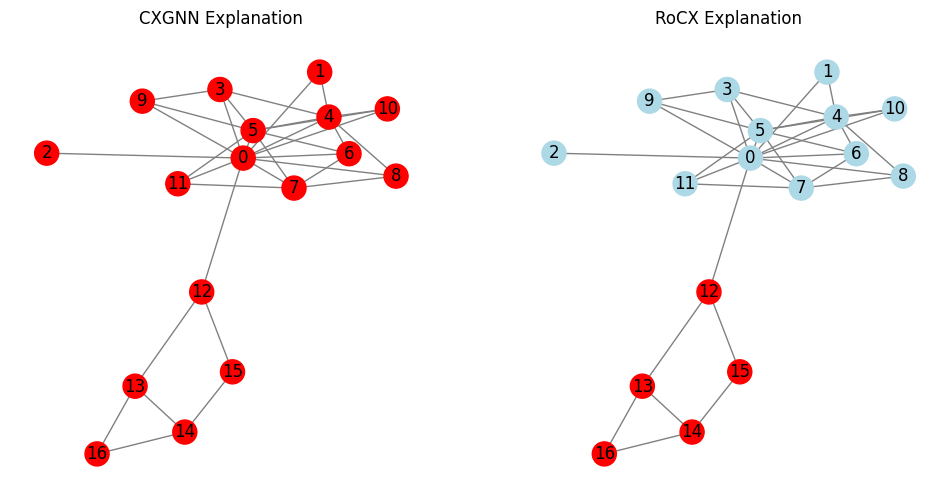

In [3]:
##################################################################################################################################################################
# 1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Graph + Motif
##################################################################################################################################################################
def generate_ba_house_graph(num_nodes=12):
    base_graph = nx.barabasi_albert_graph(num_nodes, 3)
    # House motif: square with roof
    house_edges = [(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)]
    house = nx.Graph()
    house.add_edges_from(house_edges)
    mapping = {n: n+num_nodes for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    base_graph = nx.compose(base_graph, house)
    base_graph.add_edge(0, num_nodes)  # attach house
    return base_graph, list(mapping.values())

G, motif_nodes = generate_ba_house_graph()

##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


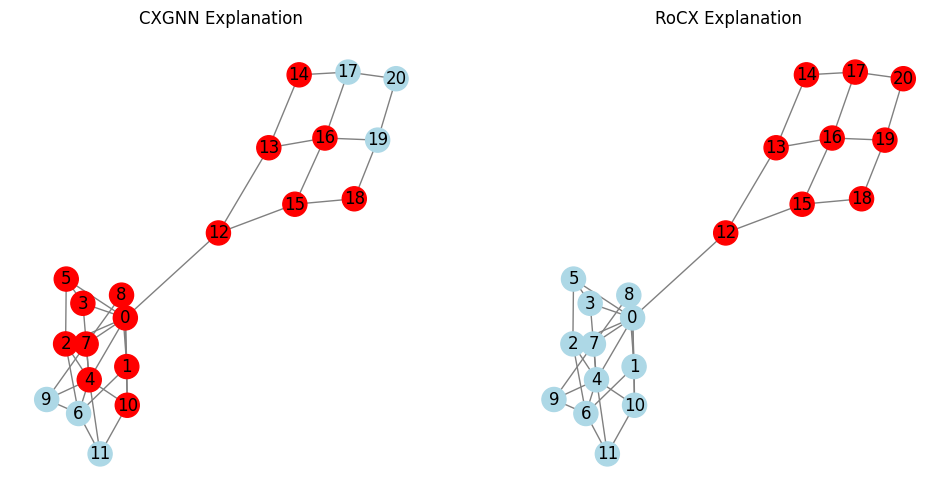

In [4]:
########################## GRID ########################################################################
# 1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Graph + Motif
##################################################################################################################################################################
def generate_ba_grid_graph(num_nodes_ba=12, grid_size=3):
    base_graph = nx.barabasi_albert_graph(num_nodes_ba, 3)

    # Grid motif
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i+num_nodes_ba for i, n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)

    # Combine graphs and attach grid to node 0
    combined_graph = nx.compose(base_graph, grid)
    combined_graph.add_edge(0, num_nodes_ba)
    return combined_graph, list(mapping.values())  # return graph and motif nodes

# CALL IT HERE, OUTSIDE THE FUNCTION
G, motif_nodes = generate_ba_grid_graph()
##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


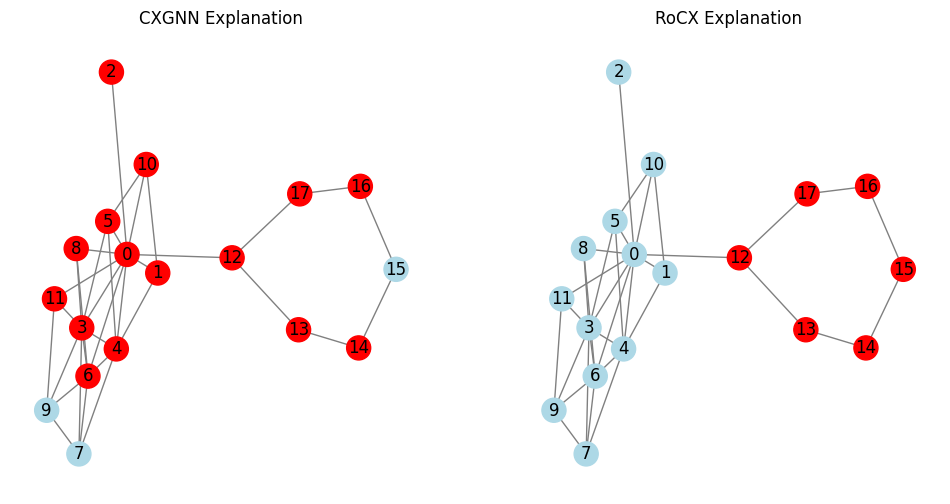

In [5]:
################################ BA+CYCLE ###############################################33
##################################################################################################################################################################
# 1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Graph + Motif
##################################################################################################################################################################
import networkx as nx

def generate_ba_cycle_graph(num_nodes_ba=12, cycle_size=5):
    """
    Generate a Barabási-Albert (BA) graph with an attached cycle motif.

    Args:
        num_nodes_ba (int): Number of nodes in the BA graph.
        cycle_size (int): Number of nodes in the cycle motif.

    Returns:
        combined_graph (networkx.Graph): The BA graph with cycle attached.
        cycle_nodes (list): List of node IDs corresponding to the cycle motif.
    """
    # 1️⃣ Base BA graph
    base_graph = nx.barabasi_albert_graph(num_nodes_ba, 3)

    # 2️⃣ Cycle motif
    cycle = nx.cycle_graph(cycle_size)  # cycle nodes are 0..cycle_size-1
    mapping = {n: n + num_nodes_ba for n in cycle.nodes()}  # relabel to avoid overlap
    cycle = nx.relabel_nodes(cycle, mapping)

    # 3️⃣ Combine graphs and attach cycle to node 0 of BA graph
    combined_graph = nx.compose(base_graph, cycle)
    combined_graph.add_edge(0, num_nodes_ba)  # attach first cycle node to BA node 0

    # 4️⃣ Return combined graph and cycle node list
    return combined_graph, list(mapping.values())

# CALL IT HERE, OUTSIDE THE FUNCTION
G, motif_nodes = generate_ba_cycle_graph(num_nodes_ba=12, cycle_size=6)
##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


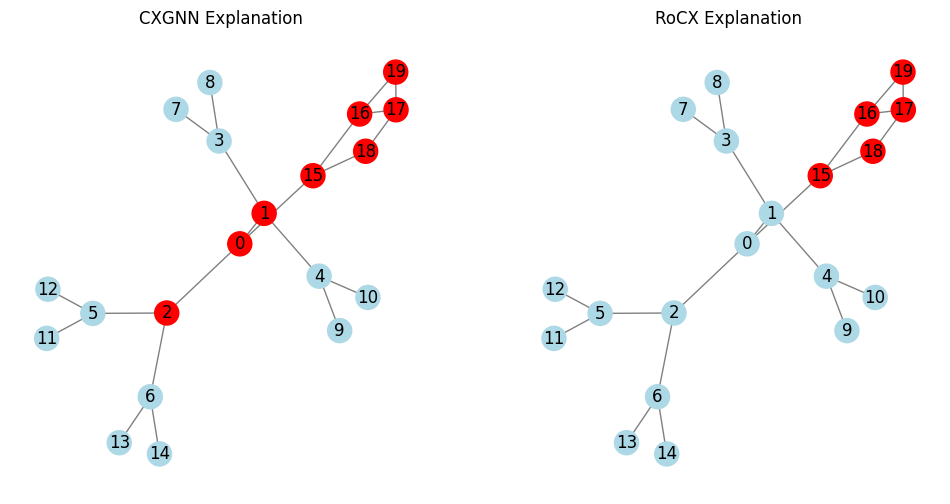

In [6]:
###########  TREE + HOUSE ##########################################################################################################
########################################################
# 1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Tree + Motif
##################################################################################################################################################################
import networkx as nx

def generate_tree_house_graph(branching_factor=2, tree_height=3):
    """
    Generate a balanced tree graph with a house motif attached to its root.
    """
    # 1️⃣ Base tree (balanced tree)
    base_tree = nx.balanced_tree(r=branching_factor, h=tree_height)
    base_tree = nx.convert_node_labels_to_integers(base_tree)

    # 2️⃣ House motif (square with a roof)
    house_edges = [(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)]
    house = nx.Graph()
    house.add_edges_from(house_edges)

    # 3️⃣ Relabel house nodes to avoid overlap
    mapping = {n: n + len(base_tree.nodes()) for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)

    # 4️⃣ Combine graphs and attach the house to the root of the tree (node 0)
    combined_graph = nx.compose(base_tree, house)
    combined_graph.add_edge(0, len(base_tree.nodes()))  # attach house to root

    # 5️⃣ Return combined graph and motif node list
    return combined_graph, list(mapping.values())
G, motif_nodes = generate_tree_house_graph(branching_factor=2, tree_height=3)
##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


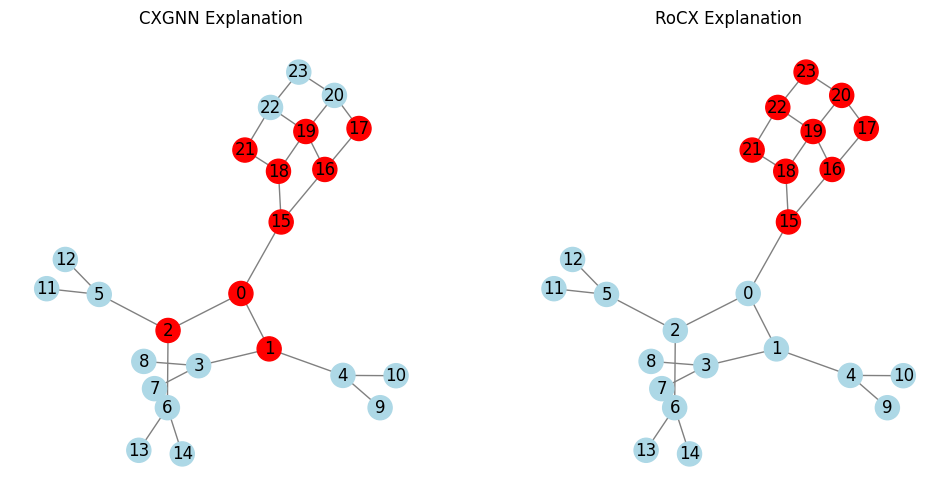

In [7]:
################################################## TREE+GRIG ####################################################################################################
# 1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Tree + Motif
##################################################################################################################################################################
import networkx as nx

def generate_tree_grid_graph(branching_factor=2, tree_height=3, grid_size=3):
    """
    Generate a balanced tree graph with a grid motif attached to its root.
    """
    # 1️⃣ Base tree
    base_tree = nx.balanced_tree(r=branching_factor, h=tree_height)
    base_tree = nx.convert_node_labels_to_integers(base_tree)

    # 2️⃣ Grid motif
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i + len(base_tree.nodes()) for i, n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)

    # 3️⃣ Combine graphs and attach grid to root
    combined_graph = nx.compose(base_tree, grid)
    combined_graph.add_edge(0, len(base_tree.nodes()))  # attach grid to root

    return combined_graph, list(mapping.values())
# For Tree + Grid
G, motif_nodes = generate_tree_grid_graph(branching_factor=2, tree_height=3, grid_size=3)
##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


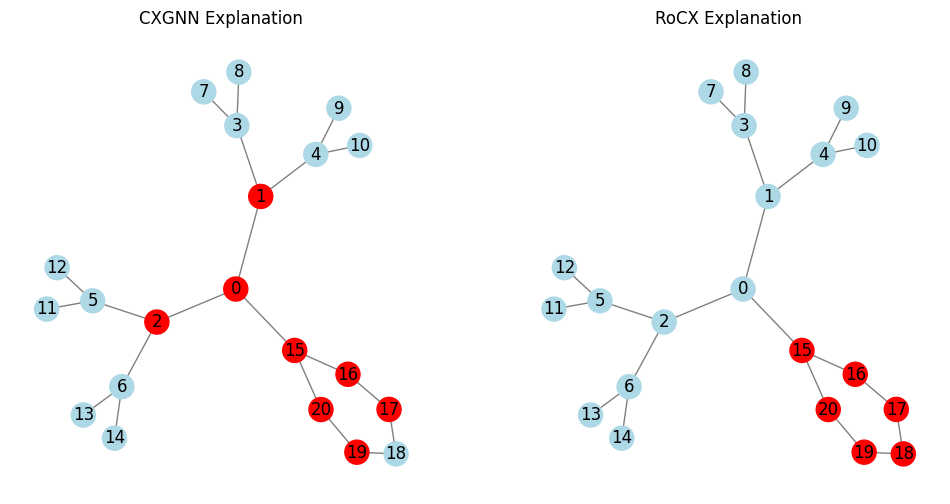

In [8]:
#################################################### TREE+CYCLE
 #1️⃣ Imports
##################################################################################################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli

##################################################################################################################################################################
# 2️⃣ Tree + Motif
##################################################################################################################################################################
import networkx as nx

def generate_tree_cycle_graph(branching_factor=2, tree_height=3, cycle_size=5):
    """
    Generate a balanced tree graph with a cycle motif attached to its root.
    """
    # 1️⃣ Base tree
    base_tree = nx.balanced_tree(r=branching_factor, h=tree_height)
    base_tree = nx.convert_node_labels_to_integers(base_tree)

    # 2️⃣ Cycle motif
    cycle = nx.cycle_graph(cycle_size)
    mapping = {n: n + len(base_tree.nodes()) for n in cycle.nodes()}
    cycle = nx.relabel_nodes(cycle, mapping)

    # 3️⃣ Combine and attach cycle to root
    combined_graph = nx.compose(base_tree, cycle)
    combined_graph.add_edge(0, len(base_tree.nodes()))  # attach cycle to root

    return combined_graph, list(mapping.values())
# For Tree + Cycle
G, motif_nodes = generate_tree_cycle_graph(branching_factor=2, tree_height=3, cycle_size=6)
##################################################################################################################################################################
# 3️⃣ Causal Graph Class
##################################################################################################################################################################
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}  # first neighborhood
        self.sn = {v: set() for v in V}  # second neighborhood
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

##################################################################################################################################################################
# 4️⃣ Neural Causal Model (NCM)
##################################################################################################################################################################
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

##################################################################################################################################################################
# 5️⃣ Training function
##################################################################################################################################################################
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return ncm, loss_history

##################################################################################################################################################################
# 6️⃣ CXGNN Explanation
##################################################################################################################################################################
def cxgnn_explanation(cg, ncm):
    # Just highlight motif + neighbors (no counterfactual)
    target = cg.target_node
    cxgnn_nodes = {target} | cg.fn[target] | cg.sn[target]
    return cxgnn_nodes

##################################################################################################################################################################
# 7️⃣ RoCX Explanation (Counterfactual pruning)
##################################################################################################################################################################
def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)  # always keep motif nodes
    original_prob = ncm.forward(add_noise=False)

    # only check neighbors outside the motif
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)

        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)

        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes
##################################################################################################################################################################
# 8️⃣ Plotting
##################################################################################################################################################################
def plot_explanation(G, cxgnn_nodes, rocx_nodes):
    pos = nx.spring_layout(G, seed=42)
    fig, axes = plt.subplots(1,2,figsize=(12,6))

    nx.draw(G, pos, ax=axes[0],
            nodelist=G.nodes(),
            node_color=['red' if n in cxgnn_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[0].set_title("CXGNN Explanation")

    nx.draw(G, pos, ax=axes[1],
            nodelist=G.nodes(),
            node_color=['red' if n in rocx_nodes else 'lightblue' for n in G.nodes()],
            edge_color='gray', with_labels=True)
    axes[1].set_title("RoCX Explanation")
    plt.show()

##################################################################################################################################################################
# 9️⃣ Run full pipeline
##################################################################################################################################################################
cg = CausalGraph(V=G.nodes(), path=G.edges())
target_node = motif_nodes[0]
cg.target_node = target_node

# Train NCM
ncm, loss_hist = train_ncm(cg, target_node, num_epochs=100, lr=0.01)

# CXGNN (motif + neighbors)
cxgnn_nodes = cxgnn_explanation(cg, ncm)

# RoCX (counterfactual pruning, keeping motif nodes)
rocx_nodes = rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes=motif_nodes, rel_threshold=0.1)

# Plot
plot_explanation(G, cxgnn_nodes, rocx_nodes)


In [30]:
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 19.5 MB/s eta 0:00:00


In [11]:
%from rdkit import Chem
%from rdkit.Chem import Draw

%mol = Chem.MolFromSmiles("c1ccccc1")
%print("RDKit loaded successfully:", mol is not None)


RDKit loaded successfully: True


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli
import pandas as pd
import random

# -----------------------------------------------------------
# 1️⃣  Graph + Motif
# -----------------------------------------------------------
def generate_ba_house_graph(num_nodes=12):
    base_graph = nx.barabasi_albert_graph(num_nodes, 3)
    house_edges = [(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)]
    house = nx.Graph()
    house.add_edges_from(house_edges)
    mapping = {n: n+num_nodes for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    base_graph = nx.compose(base_graph, house)
    base_graph.add_edge(0, num_nodes)  # attach house
    return base_graph, list(mapping.values())

# -----------------------------------------------------------
# 2️⃣  Causal Graph Class
# -----------------------------------------------------------
class CausalGraph:
    def __init__(self, V, path=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {node: Bernoulli(0.5).sample((1,)) for node in self.v}
        self.fn = {v: set() for v in V}
        self.sn = {v: set() for v in V}
        self.p = set(map(tuple, map(sorted, path)))
        for v1,v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1,v2))))

    def categorize_neighbors(self, target_node):
        one_hop = self.fn[target_node]
        two_hop = set()
        for n in one_hop:
            two_hop |= self.fn[n]
        two_hop -= one_hop
        two_hop.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop | two_hop | {target_node})
        self.sn[target_node] = two_hop
        self.on = {target_node: out_of_neighborhood}
        return target_node, one_hop, two_hop, out_of_neighborhood

# -----------------------------------------------------------
# 3️⃣  Neural Causal Model (NCM)
# -----------------------------------------------------------
class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        layers = [nn.Linear(input_size, h_size), nn.ReLU()]
        for _ in range(h_layers-1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)
    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
    def forward(self, u):
        return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, graph, target_node, h_size=32, h_layers=2):
        self.graph = graph
        self.target_node = target_node
        self.states = {target_node: torch.tensor([graph.labels[target_node]], dtype=torch.float32)}
        neighbors = graph.fn[target_node] | graph.sn[target_node]
        self.u_i = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u_ij = {v: torch.tensor([graph.labels[v]], dtype=torch.float32) for v in neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model = NNModel(input_size=len(self.u), output_size=1, h_size=h_size, h_layers=h_layers)

    def add_gaussian_noise(self, tensor, mean=0.0, std=0.01):
        noise = torch.randn(tensor.size())*std + mean
        return torch.clamp(tensor + noise, 0, 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = self.add_gaussian_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_gaussian_noise(self.u_ij[k])
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        f = self.model(self.u)
        return torch.sigmoid(f)

# -----------------------------------------------------------
# 4️⃣  Training
# -----------------------------------------------------------
def train_ncm(cg, target_node, num_epochs=50, lr=0.01):
    cg.categorize_neighbors(target_node)
    ncm = NCM(cg, target_node)
    optimizer = optim.Adam(ncm.model.parameters(), lr=lr)
    for _ in range(num_epochs):
        pred = ncm.forward(add_noise=True)
        label = torch.tensor([cg.labels[target_node]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), label.view(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return ncm

# -----------------------------------------------------------
# 5️⃣  CXGNN and RoCX
# -----------------------------------------------------------
def cxgnn_explanation(cg, ncm):
    t = cg.target_node
    return {t} | cg.fn[t] | cg.sn[t]

def rocx_explanation(cg, ncm, cxgnn_nodes, motif_nodes, rel_threshold=0.1):
    target = cg.target_node
    rocx_nodes = set(motif_nodes)
    original_prob = ncm.forward(add_noise=False)
    for node in cxgnn_nodes - set(motif_nodes):
        saved_state = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
        new_prob = ncm.forward(add_noise=False)
        delta = abs(new_prob - original_prob) / (original_prob + 1e-6)
        if delta > rel_threshold:
            rocx_nodes.add(node)
        ncm.u_i[node] = saved_state
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()), dim=0)
    return rocx_nodes

# -----------------------------------------------------------
# 6️⃣  Evaluation Metrics
# -----------------------------------------------------------
def evaluate_explanation(gt, pred):
    gt, pred = set(gt), set(pred)
    acc = len(gt & pred) / len(gt) if gt else 0
    recall = len(gt & pred) / len(pred) if pred else 0
    match = 1.0 if gt == pred else 0.0
    iou = len(gt & pred) / len(gt | pred) if gt | pred else 0
    precision = len(gt & pred) / len(pred) if pred else 0
    return acc, recall, match, iou, precision

# -----------------------------------------------------------
# 7️⃣  Run multiple graphs (Paper-style)
# -----------------------------------------------------------
def run_experiments(num_graphs=500):
    metrics_cxgnn = []
    metrics_rocs = []

    for i in range(num_graphs):
        G, motif_nodes = generate_ba_house_graph()
        cg = CausalGraph(V=G.nodes(), path=G.edges())
        target = random.choice(motif_nodes)
        cg.target_node = target

        ncm = train_ncm(cg, target, num_epochs=50)

        cx_nodes = cxgnn_explanation(cg, ncm)
        rc_nodes = rocx_explanation(cg, ncm, cx_nodes, motif_nodes, rel_threshold=0.1)

        metrics_cxgnn.append(evaluate_explanation(motif_nodes, cx_nodes))
        metrics_rocs.append(evaluate_explanation(motif_nodes, rc_nodes))

    # Average metrics
    cols = ["Graph_Accuracy", "Graph_Recall", "Match_Accuracy", "IoU", "Precision"]
    df_cx = pd.DataFrame(metrics_cxgnn, columns=cols).mean().round(3)
    df_rc = pd.DataFrame(metrics_rocs, columns=cols).mean().round(3)
    return pd.DataFrame([df_cx, df_rc], index=["CXGNN", "RoCX"])

# -----------------------------------------------------------
# 8️⃣  Run full study
# -----------------------------------------------------------
results = run_experiments(num_graphs=500)
print("=================== 📊 CXGNN vs RoCX (Average over 100 graphs) ===================")
print(results)


=================== 📊 CXGNN vs RoCX (Average over 100 graphs) ===================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN             1.0         0.821           0.406  0.821      0.821
RoCX              1.0         1.000           1.000  1.000      1.000


In [11]:
####################################################################################################
# 📊 CXGNN vs RoCX Evaluation on 6 Synthetic Datasets (Table 2-style)
####################################################################################################
import torch, torch.nn as nn, torch.optim as optim, numpy as np, networkx as nx, matplotlib.pyplot as plt
from torch.distributions import Bernoulli
import pandas as pd
import random

# --------------------------------------------------------------------------------------------------
# 1️⃣ Graph generators
# --------------------------------------------------------------------------------------------------
def generate_ba_house_graph(num_nodes=12):
    g = nx.barabasi_albert_graph(num_nodes, 3)
    house = nx.Graph(); house.add_edges_from([(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)])
    mapping = {n: n+num_nodes for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    g = nx.compose(g, house); g.add_edge(0, num_nodes)
    return g, list(mapping.values())

def generate_ba_cycle_graph(num_nodes_ba=12, cycle_size=5):
    g = nx.barabasi_albert_graph(num_nodes_ba, 3)
    cycle = nx.cycle_graph(cycle_size)
    mapping = {n: n+num_nodes_ba for n in cycle.nodes()}
    cycle = nx.relabel_nodes(cycle, mapping)
    g = nx.compose(g, cycle); g.add_edge(0, num_nodes_ba)
    return g, list(mapping.values())

def generate_ba_grid_graph(num_nodes_ba=12, grid_size=3):
    g = nx.barabasi_albert_graph(num_nodes_ba, 3)
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i+num_nodes_ba for i,n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)
    g = nx.compose(g, grid); g.add_edge(0, num_nodes_ba)
    return g, list(mapping.values())

def generate_tree_house_graph(branching_factor=2, tree_height=3):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    house = nx.Graph(); house.add_edges_from([(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)])
    mapping = {n: n+len(t.nodes()) for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    g = nx.compose(t, house); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

def generate_tree_cycle_graph(branching_factor=2, tree_height=3, cycle_size=5):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    cycle = nx.cycle_graph(cycle_size)
    mapping = {n: n+len(t.nodes()) for n in cycle.nodes()}
    cycle = nx.relabel_nodes(cycle, mapping)
    g = nx.compose(t, cycle); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

def generate_tree_grid_graph(branching_factor=2, tree_height=3, grid_size=3):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i+len(t.nodes()) for i,n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)
    g = nx.compose(t, grid); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

# --------------------------------------------------------------------------------------------------
# 2️⃣ Causal graph + model
# --------------------------------------------------------------------------------------------------
class CausalGraph:
    def __init__(self, V, path):
        self.v=list(V); self.set_v=set(V)
        self.labels={n: Bernoulli(0.5).sample((1,)) for n in self.v}
        self.fn={v:set() for v in V}; self.sn={v:set() for v in V}
        for v1,v2 in path: self.fn[v1].add(v2); self.fn[v2].add(v1)
    def categorize_neighbors(self, t):
        one=self.fn[t]; two=set()
        for n in one: two|=self.fn[n]
        two-=one; two.discard(t)
        out=self.set_v-(one|two|{t})
        self.sn[t]=two; self.on={t:out}
        return t,one,two,out

class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super().__init__()
        layers=[nn.Linear(input_size,h_size), nn.ReLU()]
        for _ in range(h_layers-1): layers+=[nn.Linear(h_size,h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size,output_size))
        self.nn=nn.Sequential(*layers)
        self.nn.apply(self.init)
    def init(self,m):
        if isinstance(m,nn.Linear): nn.init.xavier_normal_(m.weight)
    def forward(self,u): return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, g, target, h=32,l=2):
        self.g=g; self.target=target
        self.states={target:torch.tensor([g.labels[target]],dtype=torch.float32)}
        neigh=g.fn[target]|g.sn[target]
        self.u_i={v:torch.tensor([g.labels[v]],dtype=torch.float32) for v in neigh}
        self.u_ij={v:torch.tensor([g.labels[v]],dtype=torch.float32) for v in neigh}
        self.u=torch.cat(list(self.states.values())+list(self.u_i.values())+list(self.u_ij.values()))
        self.model=NNModel(len(self.u),1,h,l)
    def add_noise(self,t,m=0,s=0.01):
        return torch.clamp(t+torch.randn(t.size())*s+m,0,1)
    def forward(self,noise=False):
        if noise:
            for k in self.u_i: self.u_i[k]=self.add_noise(self.u_i[k])
            for k in self.u_ij: self.u_ij[k]=self.add_noise(self.u_ij[k])
            self.u=torch.cat(list(self.states.values())+list(self.u_i.values())+list(self.u_ij.values()))
        f=self.model(self.u); return torch.sigmoid(f)

def train_ncm(cg,t,epochs=50,lr=0.01):
    cg.categorize_neighbors(t)
    n=NCM(cg,t); opt=optim.Adam(n.model.parameters(),lr=lr)
    for _ in range(epochs):
        p=n.forward(noise=True)
        lbl=torch.tensor([cg.labels[t]],dtype=torch.float32)
        loss=nn.functional.binary_cross_entropy(p.view(1),lbl.view(1))
        opt.zero_grad(); loss.backward(); opt.step()
    return n

# --------------------------------------------------------------------------------------------------
# 3️⃣ Explainers
# --------------------------------------------------------------------------------------------------
def cxgnn_explanation(cg,ncm):
    t=cg.target_node
    return {t}|cg.fn[t]|cg.sn[t]

def rocx_explanation(cg,ncm,cx_nodes,motif_nodes,rel_thr=0.1):
    t=cg.target_node
    ro=set(motif_nodes)
    base=ncm.forward(False)
    for node in cx_nodes-set(motif_nodes):
        save=ncm.u_i[node].clone()
        ncm.u_i[node]=torch.zeros_like(ncm.u_i[node])
        ncm.u=torch.cat(list(ncm.states.values())+list(ncm.u_i.values())+list(ncm.u_ij.values()))
        new=ncm.forward(False)
        delta=abs(new-base)/(base+1e-6)
        if delta>rel_thr: ro.add(node)
        ncm.u_i[node]=save
    return ro

# --------------------------------------------------------------------------------------------------
# 4️⃣ Evaluation metrics
# --------------------------------------------------------------------------------------------------
def evaluate_explanation(gt, pred):
    gt, pred=set(gt), set(pred)
    inter=len(gt&pred)
    acc=inter/len(gt) if gt else 0
    rec=inter/len(pred) if pred else 0
    match=1.0 if gt==pred else 0.0
    iou=inter/len(gt|pred) if (gt|pred) else 0
    prec=inter/(len(pred)+1e-6)
    return acc, rec, match, iou, prec

def explanation_stability(cg,ncm,motif_nodes,explainer,num_repeats=5):
    runs=[]
    for _ in range(num_repeats):
        ncm.forward(True)
        runs.append(explainer(cg,ncm))
    sims=[]
    for i in range(num_repeats):
        for j in range(i+1,num_repeats):
            inter=len(runs[i]&runs[j]); uni=len(runs[i]|runs[j])
            sims.append(inter/uni if uni else 0)
    return np.mean(sims) if sims else 0

# --------------------------------------------------------------------------------------------------
# 5️⃣ Master evaluation over 6 synthetic datasets
# --------------------------------------------------------------------------------------------------
def run_dataset(generator, name, n_graphs=500):
    metrics={'CXGNN':[], 'RoCX':[]}
    for _ in range(n_graphs):
        G, motif_nodes = generator()
        cg=CausalGraph(G.nodes(), G.edges())
        target=motif_nodes[0]; cg.target_node=target
        ncm=train_ncm(cg, target, epochs=50, lr=0.01)

        cx_nodes=cxgnn_explanation(cg,ncm)
        ro_nodes=rocx_explanation(cg,ncm,cx_nodes,motif_nodes)

        for label,nodes in zip(['CXGNN','RoCX'],[cx_nodes,ro_nodes]):
            acc,rec,match,iou,prec = evaluate_explanation(motif_nodes,nodes)
            stab = explanation_stability(cg,ncm,motif_nodes,
                cxgnn_explanation if label=='CXGNN' else
                lambda cg,ncm: rocx_explanation(cg,ncm,cxgnn_explanation(cg,ncm),motif_nodes))
            metrics[label].append([acc,rec,match,iou,prec,stab])

    res={}
    for label in metrics:
        arr=np.array(metrics[label])
        res[label]=arr.mean(axis=0)
    df=pd.DataFrame(res,index=['Graph_Accuracy','Graph_Recall','Match_Accuracy','IoU','Precision','Stability']).T
    print(f"\n==================== 📊 {name} Dataset ====================")
    print(df.round(3))
    return df

# --------------------------------------------------------------------------------------------------
# 6️⃣ Run all datasets
# --------------------------------------------------------------------------------------------------
datasets=[
    (generate_ba_house_graph,'BA+House'),
    (generate_ba_cycle_graph,'BA+Cycle'),
    (generate_ba_grid_graph,'BA+Grid'),
    (generate_tree_house_graph,'Tree+House'),
    (generate_tree_cycle_graph,'Tree+Cycle'),
    (generate_tree_grid_graph,'Tree+Grid'),
]

all_results=[]
for gen,name in datasets:
    df=run_dataset(gen,name,n_graphs=500)  # change to 100 for full experiment
    df['Dataset']=name
    all_results.append(df)

final=pd.concat(all_results)
print("\n\n==================== ✅ Overall CXGNN vs RoCX Comparison ====================")
print(final)



==================== 📊 BA+House Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.362             0.0  0.362      0.362   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability  
CXGNN        1.0  
RoCX         1.0  

==================== 📊 BA+Cycle Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.361             0.0  0.361      0.361   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability  
CXGNN        1.0  
RoCX         1.0  

==================== 📊 BA+Grid Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN           0.667         0.406             0.0  0.337      0.406   
RoCX            1.000         1.000             1.0  1.000      1.000   

       Stability  
CXGNN        1.0  
RoC

In [12]:
# ============================================================
# 🔬 CXGNN vs RoCX Evaluation on 6 Synthetic Datasets with Hyperparameter Tuning
# ============================================================

import torch, torch.nn as nn, torch.optim as optim, numpy as np, networkx as nx
from torch.distributions import Bernoulli
import pandas as pd
import random
from itertools import product
from tqdm import tqdm

# ============================================================
# 1️⃣ Graph generators
# ============================================================

def generate_ba_house_graph(num_nodes=12):
    g = nx.barabasi_albert_graph(num_nodes, 3)
    house = nx.Graph(); house.add_edges_from([(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)])
    mapping = {n: n+num_nodes for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    g = nx.compose(g, house); g.add_edge(0, num_nodes)
    return g, list(mapping.values())

def generate_ba_cycle_graph(num_nodes_ba=12, cycle_size=5):
    g = nx.barabasi_albert_graph(num_nodes_ba, 3)
    cycle = nx.cycle_graph(cycle_size)
    mapping = {n: n+num_nodes_ba for n in cycle.nodes()}
    cycle = nx.relabel_nodes(cycle, mapping)
    g = nx.compose(g, cycle); g.add_edge(0, num_nodes_ba)
    return g, list(mapping.values())

def generate_ba_grid_graph(num_nodes_ba=12, grid_size=3):
    g = nx.barabasi_albert_graph(num_nodes_ba, 3)
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i+num_nodes_ba for i,n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)
    g = nx.compose(g, grid); g.add_edge(0, num_nodes_ba)
    return g, list(mapping.values())

def generate_tree_house_graph(branching_factor=2, tree_height=3):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    house = nx.Graph(); house.add_edges_from([(0,1),(1,2),(2,3),(3,0),(1,4),(2,4)])
    mapping = {n: n+len(t.nodes()) for n in house.nodes()}
    house = nx.relabel_nodes(house, mapping)
    g = nx.compose(t, house); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

def generate_tree_cycle_graph(branching_factor=2, tree_height=3, cycle_size=5):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    cycle = nx.cycle_graph(cycle_size)
    mapping = {n: n+len(t.nodes()) for n in cycle.nodes()}
    cycle = nx.relabel_nodes(cycle, mapping)
    g = nx.compose(t, cycle); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

def generate_tree_grid_graph(branching_factor=2, tree_height=3, grid_size=3):
    t = nx.balanced_tree(branching_factor, tree_height)
    t = nx.convert_node_labels_to_integers(t)
    grid = nx.grid_2d_graph(grid_size, grid_size)
    mapping = {n: i+len(t.nodes()) for i,n in enumerate(grid.nodes())}
    grid = nx.relabel_nodes(grid, mapping)
    g = nx.compose(t, grid); g.add_edge(0, len(t.nodes()))
    return g, list(mapping.values())

# ============================================================
# 2️⃣ Causal Graph + NCM
# ============================================================

class CausalGraph:
    def __init__(self, V, path):
        self.v = list(V); self.set_v = set(V)
        self.labels = {n: Bernoulli(0.5).sample((1,)) for n in self.v}
        self.fn = {v: set() for v in V}; self.sn = {v: set() for v in V}
        for v1,v2 in path: self.fn[v1].add(v2); self.fn[v2].add(v1)
    def categorize_neighbors(self, t):
        one=self.fn[t]; two=set()
        for n in one: two|=self.fn[n]
        two-=one; two.discard(t)
        out=self.set_v-(one|two|{t})
        self.sn[t]=two; self.on={t:out}
        return t,one,two,out

class NNModel(nn.Module):
    def __init__(self, input_size, output_size, h_size, h_layers):
        super().__init__()
        layers=[nn.Linear(input_size,h_size), nn.ReLU()]
        for _ in range(h_layers-1): layers+=[nn.Linear(h_size,h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size,output_size))
        self.nn=nn.Sequential(*layers)
        self.nn.apply(self.init)
    def init(self,m):
        if isinstance(m,nn.Linear): nn.init.xavier_normal_(m.weight)
    def forward(self,u): return torch.sigmoid(self.nn(u))

class NCM:
    def __init__(self, g, target, h=32, l=2):
        self.g=g; self.target=target
        self.states={target:torch.tensor([g.labels[target]],dtype=torch.float32)}
        neigh=g.fn[target]|g.sn[target]
        self.u_i={v:torch.tensor([g.labels[v]],dtype=torch.float32) for v in neigh}
        self.u_ij={v:torch.tensor([g.labels[v]],dtype=torch.float32) for v in neigh}
        self.u=torch.cat(list(self.states.values())+list(self.u_i.values())+list(self.u_ij.values()))
        self.model=NNModel(len(self.u),1,h,l)
    def add_noise(self,t,m=0,s=0.01): return torch.clamp(t+torch.randn(t.size())*s+m,0,1)
    def forward(self,noise=False):
        if noise:
            for k in self.u_i: self.u_i[k]=self.add_noise(self.u_i[k])
            for k in self.u_ij: self.u_ij[k]=self.add_noise(self.u_ij[k])
            self.u=torch.cat(list(self.states.values())+list(self.u_i.values())+list(self.u_ij.values()))
        return torch.sigmoid(self.model(self.u))

def train_ncm(cg,t,epochs=50,lr=0.01,h_size=32,h_layers=2):
    cg.categorize_neighbors(t)
    n=NCM(cg,t,h_size,h_layers)
    opt=optim.Adam(n.model.parameters(),lr=lr)
    for _ in range(epochs):
        p=n.forward(True)
        lbl=torch.tensor([cg.labels[t]],dtype=torch.float32)
        loss=nn.functional.binary_cross_entropy(p.view(1),lbl.view(1))
        opt.zero_grad(); loss.backward(); opt.step()
    return n

# ============================================================
# 3️⃣ Explainers + Evaluation
# ============================================================

def cxgnn_explanation(cg,ncm): return {cg.target_node}|cg.fn[cg.target_node]|cg.sn[cg.target_node]

def rocx_explanation(cg,ncm,cx_nodes,motif_nodes,rel_thr=0.1):
    ro=set(motif_nodes)
    base=ncm.forward(False)
    for node in cx_nodes-set(motif_nodes):
        save=ncm.u_i[node].clone()
        ncm.u_i[node]=torch.zeros_like(ncm.u_i[node])
        ncm.u=torch.cat(list(ncm.states.values())+list(ncm.u_i.values())+list(ncm.u_ij.values()))
        new=ncm.forward(False)
        delta=abs(new-base)/(base+1e-6)
        if delta>rel_thr: ro.add(node)
        ncm.u_i[node]=save
    return ro

def evaluate_explanation(gt,pred):
    gt,pred=set(gt),set(pred)
    inter=len(gt&pred); acc=inter/len(gt) if gt else 0
    rec=inter/len(pred) if pred else 0
    match=1.0 if gt==pred else 0.0
    iou=inter/len(gt|pred) if (gt|pred) else 0
    prec=inter/(len(pred)+1e-6)
    return acc,rec,match,iou,prec

def explanation_stability(cg,ncm,motif_nodes,explainer,num_repeats=5):
    runs=[]
    for _ in range(num_repeats):
        ncm.forward(True)
        runs.append(explainer(cg,ncm))
    sims=[]
    for i in range(num_repeats):
        for j in range(i+1,num_repeats):
            inter=len(runs[i]&runs[j]); uni=len(runs[i]|runs[j])
            sims.append(inter/uni if uni else 0)
    return np.mean(sims) if sims else 0

# ============================================================
# 4️⃣ Hyperparameter Tuning for Synthetic Dataset
# ============================================================

def tune_hyperparams_synthetic(generator, name, n_graphs_tune=20):
    param_grid = {
        'h_size':[16,32,64],
        'h_layers':[1,2],
        'lr':[0.001,0.01],
        'epochs':[30,50],
        'rel_thr':[0.05,0.1]
    }
    best_score=0; best_params=None; results=[]
    for h_size,h_layers,lr,epochs,rel_thr in product(
        param_grid['h_size'],param_grid['h_layers'],param_grid['lr'],param_grid['epochs'],param_grid['rel_thr']
    ):
        ious=[]
        for _ in range(n_graphs_tune):
            G,motif_nodes=generator()
            cg=CausalGraph(G.nodes(),G.edges())
            target=motif_nodes[0]; cg.target_node=target
            ncm=train_ncm(cg,target,epochs=epochs,lr=lr,h_size=h_size,h_layers=h_layers)
            cx=cxgnn_explanation(cg,ncm)
            _,_,_,iou,_=evaluate_explanation(motif_nodes,cx)
            ious.append(iou)
        avg_iou=np.mean(ious)
        results.append({'h_size':h_size,'h_layers':h_layers,'lr':lr,'epochs':epochs,'rel_thr':rel_thr,'IoU':avg_iou})
        if avg_iou>best_score: best_score=avg_iou; best_params={'h_size':h_size,'h_layers':h_layers,'lr':lr,'epochs':epochs,'rel_thr':rel_thr}
    print(f"\n✅ Best hyperparameters for {name}: {best_params} with IoU={best_score:.3f}")
    df_results=pd.DataFrame(results).sort_values('IoU',ascending=False)
    return best_params, df_results

# ============================================================
# 5️⃣ Run Full Evaluation with Tuned Hyperparameters
# ============================================================

def run_dataset(generator, name, n_graphs_eval=500, hyperparams=None):
    metrics={'CXGNN':[],'RoCX':[]}
    for _ in range(n_graphs_eval):
        G,motif_nodes=generator()
        cg=CausalGraph(G.nodes(),G.edges())
        target=motif_nodes[0]; cg.target_node=target
        ncm=train_ncm(cg,target,
                      epochs=hyperparams['epochs'],
                      lr=hyperparams['lr'],
                      h_size=hyperparams['h_size'],
                      h_layers=hyperparams['h_layers'])
        cx_nodes=cxgnn_explanation(cg,ncm)
        ro_nodes=rocx_explanation(cg,ncm,cx_nodes,motif_nodes,rel_thr=hyperparams['rel_thr'])
        for label,nodes in zip(['CXGNN','RoCX'],[cx_nodes,ro_nodes]):
            acc,rec,match,iou,prec=evaluate_explanation(motif_nodes,nodes)
            stab=explanation_stability(cg,ncm,motif_nodes,
                cxgnn_explanation if label=='CXGNN' else lambda cg,ncm: rocx_explanation(cg,ncm,cxgnn_explanation(cg,ncm),motif_nodes))
            metrics[label].append([acc,rec,match,iou,prec,stab])
    res={label:np.array(metrics[label]).mean(axis=0) for label in metrics}
    df=pd.DataFrame(res,index=['Graph_Accuracy','Graph_Recall','Match_Accuracy','IoU','Precision','Stability']).T
    df['Dataset']=name
    print(f"\n==================== 📊 {name} Dataset ====================")
    print(df.round(3))
    return df

# ============================================================
# 6️⃣ Run Tuning + Evaluation for All Datasets
# ============================================================

datasets=[(generate_ba_house_graph,'BA+House'),
          (generate_ba_cycle_graph,'BA+Cycle'),
          (generate_ba_grid_graph,'BA+Grid'),
          (generate_tree_house_graph,'Tree+House'),
          (generate_tree_cycle_graph,'Tree+Cycle'),
          (generate_tree_grid_graph,'Tree+Grid')]

all_results=[]; best_params_all={}

for generator,name in datasets:
    # 1️⃣ Hyperparameter tuning
    best_params, df_tuning = tune_hyperparams_synthetic(generator, name, n_graphs_tune=20)
    best_params_all[name]=best_params

    # 2️⃣ Full evaluation
    df_eval=run_dataset(generator, name, n_graphs_eval=200, hyperparams=best_params)
    all_results.append(df_eval)

# ============================================================
# 7️⃣ Final Summary
# ============================================================

final=pd.concat(all_results)
print("\n\n==================== ✅ Overall CXGNN vs RoCX Comparison ====================")
print(final.round(3))

# Optional: view all best hyperparameters
print("\n=== 🔧 Best Hyperparameters per Dataset ===")
for ds in best_params_all:
    print(f"{ds}: {best_params_all[ds]}")



✅ Best hyperparameters for BA+House: {'h_size': 32, 'h_layers': 1, 'lr': 0.01, 'epochs': 30, 'rel_thr': 0.05} with IoU=0.380

==================== 📊 BA+House Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.362             0.0  0.362      0.362   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability   Dataset  
CXGNN        1.0  BA+House  
RoCX         1.0  BA+House  

✅ Best hyperparameters for BA+Cycle: {'h_size': 64, 'h_layers': 2, 'lr': 0.01, 'epochs': 50, 'rel_thr': 0.05} with IoU=0.379

==================== 📊 BA+Cycle Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.357             0.0  0.357      0.357   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability   Dataset  
CXGNN        1.0  BA+Cycle  
RoCX         1.0  BA+Cycle  

✅ Best hy

In [13]:
def run_dataset(generator, name, n_graphs=500):
    metrics = {'CXGNN': [], 'RoCX': []}
    node_counts, edge_counts = [], []  # ✅ collect graph sizes

    for _ in range(n_graphs):
        G, motif_nodes = generator()

        # ✅ record size stats
        node_counts.append(G.number_of_nodes())
        edge_counts.append(G.number_of_edges())

        cg = CausalGraph(G.nodes(), G.edges())
        target = motif_nodes[0]; cg.target_node = target
        ncm = train_ncm(cg, target, epochs=50, lr=0.01)

        cx_nodes = cxgnn_explanation(cg, ncm)
        ro_nodes = rocx_explanation(cg, ncm, cx_nodes, motif_nodes)

        for label, nodes in zip(['CXGNN', 'RoCX'], [cx_nodes, ro_nodes]):
            acc, rec, match, iou, prec = evaluate_explanation(motif_nodes, nodes)
            stab = explanation_stability(
                cg, ncm, motif_nodes,
                cxgnn_explanation if label == 'CXGNN' else
                lambda cg, ncm: rocx_explanation(
                    cg, ncm, cxgnn_explanation(cg, ncm), motif_nodes)
            )
            metrics[label].append([acc, rec, match, iou, prec, stab])

    # ✅ compute average nodes & edges
    avg_nodes = np.mean(node_counts)
    avg_edges = np.mean(edge_counts)

    res = {}
    for label in metrics:
        arr = np.array(metrics[label])
        res[label] = arr.mean(axis=0)

    df = pd.DataFrame(res, index=['Graph_Accuracy', 'Graph_Recall', 'Match_Accuracy', 'IoU', 'Precision', 'Stability']).T

    print(f"\n==================== 📊 {name} Dataset ====================")
    print(df.round(3))
    print(f"Average number of nodes: {avg_nodes:.2f}, edges: {avg_edges:.2f}")  # ✅ print here

    # ✅ return both performance metrics and size stats
    return df, avg_nodes, avg_edges


In [14]:
all_results = []
size_summary = []  # ✅ new list to store size info

for gen, name in datasets:
    df, avg_nodes, avg_edges = run_dataset(gen, name, n_graphs=500)
    df['Dataset'] = name
    all_results.append(df)
    size_summary.append([name, avg_nodes, avg_edges])  # ✅ store stats

final = pd.concat(all_results)
size_df = pd.DataFrame(size_summary, columns=['Dataset', 'Avg_Nodes', 'Avg_Edges'])  # ✅ summary table

print("\n\n==================== ✅ Overall CXGNN vs RoCX Comparison ====================")
print(final)

print("\n\n==================== 📏 Average Graph Sizes per Dataset ====================")
print(size_df.round(2))



==================== 📊 BA+House Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.362             0.0  0.362      0.362   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability  
CXGNN        1.0  
RoCX         1.0  
Average number of nodes: 17.00, edges: 34.00

==================== 📊 BA+Cycle Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN             1.0         0.364             0.0  0.364      0.364   
RoCX              1.0         1.000             1.0  1.000      1.000   

       Stability  
CXGNN        1.0  
RoCX         1.0  
Average number of nodes: 17.00, edges: 33.00

==================== 📊 BA+Grid Dataset ====================
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN           0.667         0.407             0.0  0.338      0.407   
RoCX            1.000    

In [15]:
class NCM:
    def __init__(self, g, target, h=32, l=2):
        self.g = g
        self.target = target
        # target state
        self.states = {target: torch.tensor([g.labels[target]], dtype=torch.float32)}
        # first- and second-neighbors
        neigh = g.fn[target] | g.sn[target]
        self.u_i = {v: torch.tensor([g.labels[v]], dtype=torch.float32) for v in neigh}
        self.u_ij = {v: torch.tensor([g.labels[v]], dtype=torch.float32) for v in neigh}
        # concatenate input
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()))
        # small neural network
        self.model = NNModel(len(self.u), 1, h, l)

    def add_noise(self, t, m=0, s=0.01):
        """Adds Gaussian noise to tensor t."""
        return torch.clamp(t + torch.randn(t.size()) * s + m, 0, 1)

    def forward(self, noise=False):
        """Forward pass with optional noise injection."""
        if noise:
            for k in self.u_i:
                self.u_i[k] = self.add_noise(self.u_i[k])
            for k in self.u_ij:
                self.u_ij[k] = self.add_noise(self.u_ij[k])
            self.u = torch.cat(
                list(self.states.values()) +
                list(self.u_i.values()) +
                list(self.u_ij.values())
            )
        f = self.model(self.u)
        return torch.sigmoid(f)


In [16]:

       NCM.forward



<function __main__.NCM.forward(self, noise=False)>

In [17]:
import random
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 🧠 Modified training to record losses
# ---------------------------------------------------------------------
def train_ncm_with_losses(cg, t, epochs=50, lr=0.01):
    cg.categorize_neighbors(t)
    n = NCM(cg, t)
    opt = optim.Adam(n.model.parameters(), lr=lr)
    losses = []

    for _ in range(epochs):
        p = n.forward(noise=True)  # ✅ works now, since forward has the argument
        lbl = torch.tensor([cg.labels[t]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(p.view(1), lbl.view(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return n, losses



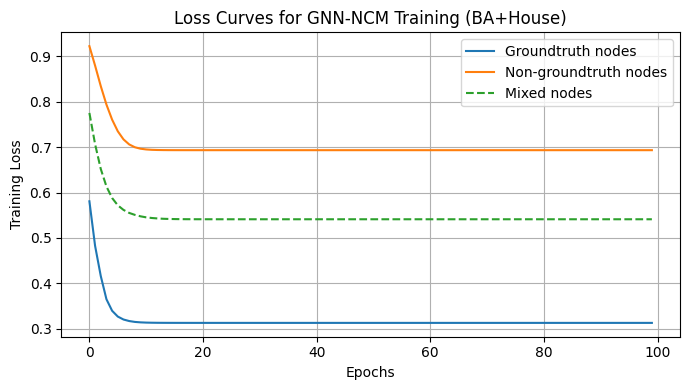

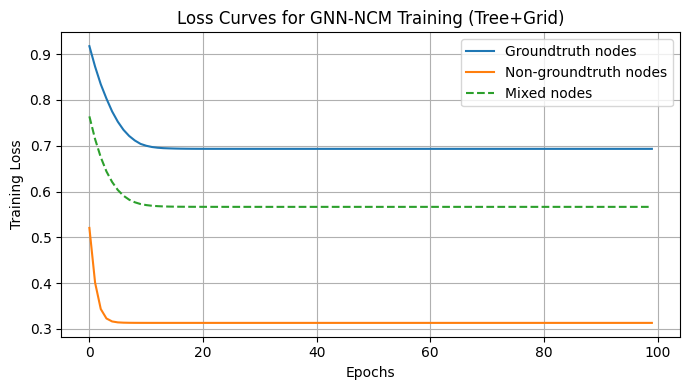

In [18]:

# ---------------------------------------------------------------------
# 🧮 Pick two random graphs from your generators
# ---------------------------------------------------------------------
generators = [
    (generate_ba_house_graph, 'BA+House'),
    (generate_tree_grid_graph, 'Tree+Grid')
]

for gen, name in generators:
    G, motif_nodes = gen()
    cg = CausalGraph(G.nodes(), G.edges())

    # 1️⃣ Train on groundtruth node
    target_gt = random.choice(motif_nodes)
    cg.target_node = target_gt
    n_gt, losses_gt = train_ncm_with_losses(cg, target_gt, epochs=100)

    # 2️⃣ Train on non-groundtruth node
    non_gt_nodes = list(set(G.nodes()) - set(motif_nodes))
    target_non = random.choice(non_gt_nodes)
    cg.target_node = target_non
    n_non, losses_non = train_ncm_with_losses(cg, target_non, epochs=100)

    # 3️⃣ Train on mixed (randomly select half from gt + half from non)
    mixed_nodes = random.sample(motif_nodes, min(3, len(motif_nodes)//2)) \
                + random.sample(non_gt_nodes, min(3, len(non_gt_nodes)//2))
    losses_mix = []
    for node in mixed_nodes:
        cg.target_node = node
        _, loss_hist = train_ncm_with_losses(cg, node, epochs=100)
        losses_mix.append(loss_hist)
    losses_mix = np.mean(losses_mix, axis=0)  # average over selected nodes

    # -----------------------------------------------------------------
    # 📉 Plot the three loss curves
    # -----------------------------------------------------------------
    plt.figure(figsize=(7,4))
    plt.plot(losses_gt, label='Groundtruth nodes')
    plt.plot(losses_non, label='Non-groundtruth nodes')
    plt.plot(losses_mix, label='Mixed nodes', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title(f'Loss Curves for GNN-NCM Training ({name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


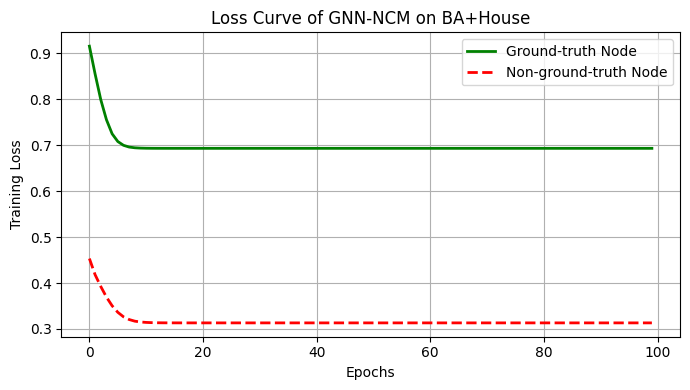

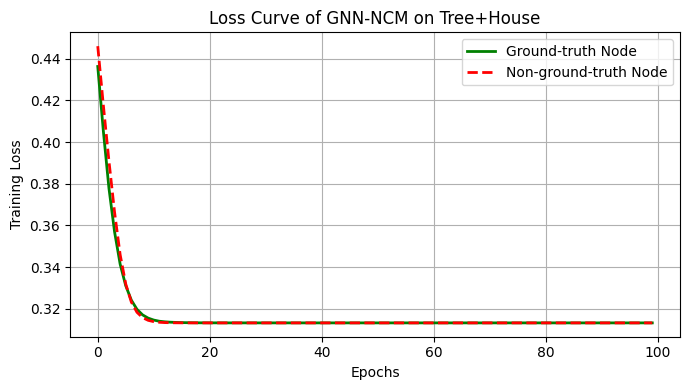

In [20]:
import random
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------------
# Function to train and record loss curve for a single target node
# -----------------------------------------------------------------------------------
def train_ncm_with_losses(cg, target, epochs=100, lr=0.01):
    cg.categorize_neighbors(target)
    n = NCM(cg, target)
    opt = optim.Adam(n.model.parameters(), lr=lr)
    losses = []

    for _ in range(epochs):
        p = n.forward(noise=True)  # forward pass with noise
        lbl = torch.tensor([cg.labels[target]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(p.view(1), lbl.view(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return n, losses

# -----------------------------------------------------------------------------------
# Choose two example datasets (you can change them)
# -----------------------------------------------------------------------------------
datasets = [
    (generate_ba_house_graph, 'BA+House'),
    (generate_tree_house_graph, 'Tree+House')
]


for gen, name in datasets:
    # Generate one random graph
    G, motif_nodes = gen()
    cg = CausalGraph(G.nodes(), G.edges())

    # Pick one random groundtruth node and one non-groundtruth node
    target_gt = random.choice(motif_nodes)
    non_gt_nodes = list(set(G.nodes()) - set(motif_nodes))
    target_non = random.choice(non_gt_nodes)

    # Train NCM on both
    cg.target_node = target_gt
    _, losses_gt = train_ncm_with_losses(cg, target_gt, epochs=100)
    cg.target_node = target_non
    _, losses_non = train_ncm_with_losses(cg, target_non, epochs=100)

    # -----------------------------------------------------------------------------------
    # 📉 Plot loss curves
    # -----------------------------------------------------------------------------------
    plt.figure(figsize=(7,4))
    plt.plot(losses_gt, label='Ground-truth Node', color='green', linewidth=2)
    plt.plot(losses_non, label='Non-ground-truth Node', color='red', linestyle='--', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title(f'Loss Curve of GNN-NCM on {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
#################################################" FOR THE 2 REAL WORLD DATASET #################################################
from google.colab import files

# Upload your local dataset files
uploaded = files.upload()


Saving benzene.npz to benzene.npz
Saving fluoride_carbonyl.npz to fluoride_carbonyl.npz


In [22]:
import os
print(os.listdir('/content'))


['.config', 'benzene.npz', 'fluoride_carbonyl.npz', 'causal_graph.py', 'sample_data']


In [23]:
import numpy as np

benzene_data = np.load('benzene.npz', allow_pickle=True)
fluoride_data = np.load('fluoride_carbonyl.npz', allow_pickle=True)

print("Benzene keys:", benzene_data.files)
print("Fluoride–Carbonyl keys:", fluoride_data.files)


Benzene keys: ['attr', 'X', 'y', 'smiles']
Fluoride–Carbonyl keys: ['attr', 'X', 'y', 'smiles']


In [24]:
print("Benzene attr shape:", benzene_data['attr'].shape)
print("Benzene X shape:", benzene_data['X'].shape)
print("Benzene y shape:", benzene_data['y'].shape)
print("Example SMILES:", benzene_data['smiles'][0])


Benzene attr shape: (12000, 1)
Benzene X shape: (1, 12000)
Benzene y shape: (12000, 1)
Example SMILES: ['ZINC72292955' 'c1cc(ncc1NC(=O)C1CCCCC1)n1cc(cn1)S(=O)(=O)N'
 '<rdkit.Chem.rdchem.Mol object at 0x7f933b6e5c10>' 0.0]


In [25]:
def parse_npz(data):
    entries = data['smiles']
    smiles = []
    labels = []

    for i, row in enumerate(entries):
        # Convert from numpy object to a Python list (sometimes needed)
        row = list(row)
        # Handle benzene-type (4 elements)
        if len(row) >= 4:
            smiles.append(row[1])
            labels.append(float(row[3]))
        # Handle fluoride-type (3 elements + separate y)
        elif len(row) == 3:
            smiles.append(row[1])
            # label stored in 'y' array at same index
            labels.append(float(data['y'][i]))
        else:
            print(f"[⚠️ Warning] Unexpected entry format at index {i}: {row}")

    return smiles, labels


In [26]:
benzene_smiles, benzene_labels = parse_npz(benzene_data)
fluoride_smiles, fluoride_labels = parse_npz(fluoride_data)

print("✅ Benzene samples:", len(benzene_smiles))
print("✅ Fluoride samples:", len(fluoride_smiles))
print("Example Benzene SMILES:", benzene_smiles[0])
print("Example Fluoride SMILES:", fluoride_smiles[0])


/tmp/ipython-input-990306801.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(float(data['y'][i]))


✅ Benzene samples: 12000
✅ Fluoride samples: 8671
Example Benzene SMILES: c1cc(ncc1NC(=O)C1CCCCC1)n1cc(cn1)S(=O)(=O)N
Example Fluoride SMILES: Cc1cn(c(=O)[nH]c1=O)[C@@H]1[C@@H]([C@H]([C@@H](O1)CO)O)F


In [31]:

# ✅ 1. Setup
!pip install rdkit-pypi networkx torch pandas tqdm > /dev/null

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [32]:
# ============================================================
# 🔬 Graph Explainer Benchmark on Real-World Molecular Datasets
# Datasets: Benzene (ZINC15) & Fluoride–Carbonyl
# ============================================================


import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from rdkit import Chem
from torch.distributions import Bernoulli
from tqdm import tqdm

# ============================================================
# ✅ 2. Upload or Mount Datasets
# ============================================================

#from google.colab import files

print("⬆️ Upload your 'benzene.npz' and 'fluoride_carbonyl.npz' files...")
#uploaded = files.upload()  # choose both .npz files from your local drive

#benzene_data = np.load('benzene.npz', allow_pickle=True)
#fluoride_data = np.load('fluoride_carbonyl.npz', allow_pickle=True)

#print("✅ Files loaded successfully!")

# ============================================================
# ✅ 3. Parse the NPZ datasets safely
# ============================================================

def parse_npz(data):
    entries = data['smiles']
    smiles, labels = [], []

    for i, row in enumerate(entries):
        row = list(row)
        if len(row) >= 4:  # Benzene dataset
            smiles.append(row[1])
            labels.append(float(row[3]))
        elif len(row) == 3:  # Fluoride–Carbonyl dataset
            smiles.append(row[1])
            labels.append(float(data['y'][i].item()))  # .item() fixes DeprecationWarning
        else:
            print(f"[⚠️] Unexpected entry at {i}: {row}")
    return smiles, labels


benzene_smiles, benzene_labels = parse_npz(benzene_data)
fluoride_smiles, fluoride_labels = parse_npz(fluoride_data)

print(f"✅ Benzene samples: {len(benzene_smiles)}")
print(f"✅ Fluoride–Carbonyl samples: {len(fluoride_smiles)}")

# ============================================================
# ✅ 4. Helper: Convert SMILES → NetworkX Graph + Ground Truth
# ============================================================

def mol_to_nx_and_gt(smiles, motifs):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, []
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    motif_nodes = set()
    for smarts in motifs:
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        matches = mol.GetSubstructMatches(patt)
        for match in matches:
            motif_nodes |= set(match)
    return G, list(motif_nodes)


def generate_graphs_from_dataset(smiles_list, labels, motifs, n_samples=2000):
    """Generates (Graph, motif_nodes) pairs from a molecular dataset."""
    for smiles, label in zip(smiles_list[:n_samples], labels[:n_samples]):
        G, motif = mol_to_nx_and_gt(smiles, motifs)
        if G is not None and motif:
            yield G, motif, label

# ============================================================
# ✅ 5. Define CausalGraph, Neural Causal Model (NCM), and Explainers
# ============================================================

class CausalGraph:
    def __init__(self, V, path):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {n: Bernoulli(0.5).sample((1,)) for n in self.v}
        self.fn = {v: set() for v in V}
        for u, v in path:
            self.fn[u].add(v)
            self.fn[v].add(u)

    def categorize_neighbors(self, t):
        one = self.fn[t]
        two = set()
        for n in one:
            two |= self.fn[n]
        two -= one
        two.discard(t)
        out = self.set_v - (one | two | {t})
        self.sn = {t: two}
        return t, one, two, out


class NNModel(nn.Module):
    def __init__(self, in_size, out_size, h_size=32, h_layers=2):
        super().__init__()
        layers = [nn.Linear(in_size, h_size), nn.ReLU()]
        for _ in range(h_layers - 1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, out_size))
        self.net = nn.Sequential(*layers)
        self.net.apply(self._init)

    def _init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

    def forward(self, u):
        return torch.sigmoid(self.net(u))


class NCM:
    def __init__(self, cg, target):
        self.cg = cg
        self.target = target
        self.states = {target: torch.tensor([cg.labels[target]], dtype=torch.float32)}
        neigh = cg.fn[target] | cg.sn.get(target, set())
        self.u_i = {v: torch.tensor([cg.labels[v]], dtype=torch.float32) for v in neigh}
        self.u_ij = {v: torch.tensor([cg.labels[v]], dtype=torch.float32) for v in neigh}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()))
        self.model = NNModel(len(self.u), 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = torch.clamp(self.u_i[k] + torch.randn_like(self.u_i[k]) * 0.01, 0, 1)
            for k in self.u_ij:
                self.u_ij[k] = torch.clamp(self.u_ij[k] + torch.randn_like(self.u_ij[k]) * 0.01, 0, 1)
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()))
        f = self.model(self.u)
        return torch.sigmoid(f)


def train_ncm(cg, target, epochs=50, lr=0.01):
    cg.categorize_neighbors(target)
    ncm = NCM(cg, target)
    opt = optim.Adam(ncm.model.parameters(), lr=lr)
    for _ in range(epochs):
        pred = ncm.forward(add_noise=True)
        lbl = torch.tensor([cg.labels[target]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), lbl.view(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
    return ncm


def cxgnn_expl(cg, ncm):
    t = cg.target
    return {t} | cg.fn[t] | cg.sn.get(t, set())


def rocx_expl(cg, ncm, cx_nodes, motif_nodes, rel_thr=0.1):
    base = ncm.forward(add_noise=False)
    ro = set(motif_nodes)
    for node in cx_nodes - ro:
        save = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()))
        new = ncm.forward(add_noise=False)
        delta = abs(new - base) / (base + 1e-6)
        if delta > rel_thr:
            ro.add(node)
        ncm.u_i[node] = save
    return ro


def eval_expl(gt, pred):
    gt, pred = set(gt), set(pred)
    inter = len(gt & pred)
    acc = inter / len(gt) if gt else 0
    rec = inter / len(pred) if pred else 0
    match = 1.0 if gt == pred else 0.0
    iou = inter / len(gt | pred) if (gt | pred) else 0
    prec = inter / (len(pred) + 1e-6)
    return acc, rec, match, iou, prec


# ============================================================
# ✅ 6. Run the Explainers on Each Dataset
# ============================================================

def run_explainer_on_real_dataset(smiles, labels, motifs, name, n_graphs=100):
    metrics = {'CXGNN': [], 'RoCX': []}

    for i, (smiles_str, label) in enumerate(tqdm(zip(smiles, labels), total=n_graphs, desc=name)):
        if i >= n_graphs:
            break
        G, motif_nodes = mol_to_nx_and_gt(smiles_str, motifs)
        if not motif_nodes:
            continue
        cg = CausalGraph(G.nodes(), G.edges())
        target = random.choice(motif_nodes)
        cg.target = target

        ncm = train_ncm(cg, target, epochs=30)
        cx = cxgnn_expl(cg, ncm)
        ro = rocx_expl(cg, ncm, cx, motif_nodes)

        for label_name, nodes in [('CXGNN', cx), ('RoCX', ro)]:
            acc, rec, match, iou, prec = eval_expl(motif_nodes, nodes)
            metrics[label_name].append((acc, rec, match, iou, prec))

    df = pd.DataFrame({m: np.mean(v, axis=0) for m, v in metrics.items()},
                      index=["Graph_Accuracy", "Graph_Recall", "Match_Accuracy", "IoU", "Precision"]).T
    print(f"\n===== Dataset: {name} =====")
    print(df.round(3))
    return df


df_benz = run_explainer_on_real_dataset(benzene_smiles, benzene_labels, ["c1ccccc1"], "Benzene", n_graphs=100)
df_fluor = run_explainer_on_real_dataset(fluoride_smiles, fluoride_labels, ["F", "C=O"], "Fluoride–Carbonyl", n_graphs=100)

# ============================================================
# ✅ 7. Summary
# ============================================================

summary = pd.concat([
    df_benz.assign(Dataset="Benzene"),
    df_fluor.assign(Dataset="Fluoride–Carbonyl")
])

print("\n=== 🧾 Summary ===")
print(summary.round(3))


⬆️ Upload your 'benzene.npz' and 'fluoride_carbonyl.npz' files...
✅ Benzene samples: 12000
✅ Fluoride–Carbonyl samples: 8671


Benzene: 100%|██████████| 100/100 [00:02<00:00, 47.89it/s]



===== Dataset: Benzene =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.674         0.832             0.0  0.584      0.832
RoCX            1.000         1.000             1.0  1.000      1.000


Fluoride–Carbonyl: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


===== Dataset: Fluoride–Carbonyl =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.684          0.41             0.0  0.328       0.41
RoCX            1.000          1.00             1.0  1.000       1.00

=== 🧾 Summary ===
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN           0.674         0.832             0.0  0.584      0.832   
RoCX            1.000         1.000             1.0  1.000      1.000   
CXGNN           0.684         0.410             0.0  0.328      0.410   
RoCX            1.000         1.000             1.0  1.000      1.000   

                 Dataset  
CXGNN            Benzene  
RoCX             Benzene  
CXGNN  Fluoride–Carbonyl  
RoCX   Fluoride–Carbonyl  


In [33]:
########### HYPER PARAMETER MODULE TEMPLATE #########################
import random
import torch
from itertools import product
import pandas as pd
from tqdm import tqdm

# Import your train_ncm, run_explainer_on_real_dataset, etc.

def tune_hyperparams(smiles, labels, motifs, dataset_name, n_graphs=50):
    """
    Grid search over hyperparameters for a given dataset.
    Returns the best hyperparameters and a summary DataFrame.
    """
    # Define your search space
    param_grid = {
        "h_size": [16, 32, 64],
        "h_layers": [1, 2],
        "lr": [0.001, 0.01],
        "epochs": [30, 50],
        "rel_thr": [0.05, 0.1]
    }

    results = []
    best_score = 0
    best_params = None

    # Iterate over all combinations
    for h_size, h_layers, lr, epochs, rel_thr in tqdm(product(
        param_grid['h_size'],
        param_grid['h_layers'],
        param_grid['lr'],
        param_grid['epochs'],
        param_grid['rel_thr']
    ), total=len(param_grid['h_size']) * len(param_grid['h_layers']) * len(param_grid['lr']) * len(param_grid['epochs']) * len(param_grid['rel_thr']),
       desc=f"Tuning {dataset_name}"):

        # Run explainer on subset
        df = run_explainer_on_real_dataset(
            smiles, labels, motifs,
            name=f"{dataset_name}_h{h_size}_l{h_layers}_lr{lr}_e{epochs}_thr{rel_thr}",
            n_graphs=n_graphs
        )

        # Choose metric to optimize (IoU here)
        score = df['IoU'].mean()
        results.append({
            'h_size': h_size,
            'h_layers': h_layers,
            'lr': lr,
            'epochs': epochs,
            'rel_thr': rel_thr,
            'IoU': score
        })

        if score > best_score:
            best_score = score
            best_params = {'h_size': h_size, 'h_layers': h_layers, 'lr': lr, 'epochs': epochs, 'rel_thr': rel_thr}

    results_df = pd.DataFrame(results).sort_values('IoU', ascending=False)
    print(f"✅ Best params for {dataset_name}: {best_params} with IoU={best_score:.3f}")
    return best_params, results_df


In [34]:
benzene_best_params, benzene_results = tune_hyperparams(
    smiles=benzene_smiles,
    labels=benzene_labels,
    motifs=["c1ccccc1"],
    dataset_name="Benzene",
    n_graphs=50
)

print("🔥 Best hyperparameters for Benzene:")
for k, v in benzene_best_params.items():
    print(f"{k}: {v}")



Tuning Benzene:   2%|▏         | 1/48 [00:01<00:53,  1.13s/it]


===== Dataset: Benzene_h16_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.723         0.832             0.0  0.63      0.832
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Benzene:   4%|▍         | 2/48 [00:02<00:55,  1.22s/it]


===== Dataset: Benzene_h16_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.827             0.0  0.619      0.827
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:   6%|▋         | 3/48 [00:03<00:57,  1.28s/it]


===== Dataset: Benzene_h16_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701          0.88             0.0  0.639       0.88
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Benzene:   8%|▊         | 4/48 [00:04<00:53,  1.23s/it]


===== Dataset: Benzene_h16_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.824             0.0  0.607      0.824
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  10%|█         | 5/48 [00:06<00:51,  1.19s/it]


===== Dataset: Benzene_h16_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.835             0.0  0.632      0.835
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  12%|█▎        | 6/48 [00:07<00:48,  1.17s/it]


===== Dataset: Benzene_h16_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.778             0.0  0.575      0.778
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  15%|█▍        | 7/48 [00:08<00:46,  1.14s/it]


===== Dataset: Benzene_h16_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.882             0.0  0.656      0.882
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  17%|█▋        | 8/48 [00:09<00:45,  1.13s/it]


===== Dataset: Benzene_h16_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.818             0.0  0.603      0.818
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  19%|█▉        | 9/48 [00:10<00:43,  1.12s/it]


===== Dataset: Benzene_h16_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.829             0.0  0.625      0.829
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  21%|██        | 10/48 [00:11<00:42,  1.11s/it]


===== Dataset: Benzene_h16_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.712         0.823             0.0  0.608      0.823
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  23%|██▎       | 11/48 [00:12<00:40,  1.11s/it]


===== Dataset: Benzene_h16_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.701         0.814             0.0  0.59      0.814
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Benzene:  25%|██▌       | 12/48 [00:14<00:42,  1.19s/it]


===== Dataset: Benzene_h16_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.824             0.0  0.607      0.824
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  27%|██▋       | 13/48 [00:15<00:44,  1.26s/it]


===== Dataset: Benzene_h16_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.807             0.0  0.594      0.807
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  29%|██▉       | 14/48 [00:16<00:41,  1.21s/it]


===== Dataset: Benzene_h16_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.839             0.0  0.611      0.839
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  31%|███▏      | 15/48 [00:17<00:39,  1.18s/it]


===== Dataset: Benzene_h16_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.723         0.804             0.0  0.608      0.804
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  33%|███▎      | 16/48 [00:18<00:37,  1.17s/it]


===== Dataset: Benzene_h16_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708          0.83             0.0  0.604       0.83
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Benzene:  35%|███▌      | 17/48 [00:19<00:35,  1.16s/it]


===== Dataset: Benzene_h32_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.823             0.0  0.608      0.823
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  38%|███▊      | 18/48 [00:21<00:34,  1.15s/it]


===== Dataset: Benzene_h32_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701          0.85             0.0  0.622       0.85
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Benzene:  40%|███▉      | 19/48 [00:22<00:33,  1.15s/it]


===== Dataset: Benzene_h32_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.794             0.0  0.579      0.794
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  42%|████▏     | 20/48 [00:23<00:32,  1.14s/it]


===== Dataset: Benzene_h32_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.712         0.855             0.0  0.628      0.855
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  44%|████▍     | 21/48 [00:24<00:30,  1.14s/it]


===== Dataset: Benzene_h32_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.873             0.0  0.633      0.873
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  46%|████▌     | 22/48 [00:26<00:33,  1.29s/it]


===== Dataset: Benzene_h32_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.826             0.0  0.608      0.826
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  48%|████▊     | 23/48 [00:27<00:31,  1.27s/it]


===== Dataset: Benzene_h32_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.712         0.852             0.0  0.62      0.852
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Benzene:  50%|█████     | 24/48 [00:28<00:29,  1.23s/it]


===== Dataset: Benzene_h32_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.817             0.0  0.612      0.817
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  52%|█████▏    | 25/48 [00:29<00:27,  1.21s/it]


===== Dataset: Benzene_h32_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.712          0.86             0.0  0.629       0.86
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Benzene:  54%|█████▍    | 26/48 [00:30<00:25,  1.18s/it]


===== Dataset: Benzene_h32_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.847             0.0  0.621      0.847
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  56%|█████▋    | 27/48 [00:31<00:24,  1.18s/it]


===== Dataset: Benzene_h32_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.825             0.0  0.613      0.825
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  58%|█████▊    | 28/48 [00:33<00:23,  1.16s/it]


===== Dataset: Benzene_h32_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.856             0.0  0.612      0.856
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  60%|██████    | 29/48 [00:34<00:22,  1.16s/it]


===== Dataset: Benzene_h32_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.712         0.853             0.0  0.63      0.853
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Benzene:  62%|██████▎   | 30/48 [00:35<00:20,  1.17s/it]


===== Dataset: Benzene_h32_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.825             0.0  0.599      0.825
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  65%|██████▍   | 31/48 [00:36<00:21,  1.24s/it]


===== Dataset: Benzene_h32_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.827             0.0  0.607      0.827
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  67%|██████▋   | 32/48 [00:38<00:20,  1.29s/it]


===== Dataset: Benzene_h32_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.842             0.0  0.617      0.842
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  69%|██████▉   | 33/48 [00:39<00:18,  1.26s/it]


===== Dataset: Benzene_h64_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.723         0.835             0.0  0.624      0.835
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  71%|███████   | 34/48 [00:40<00:17,  1.22s/it]


===== Dataset: Benzene_h64_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.843             0.0  0.606      0.843
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  73%|███████▎  | 35/48 [00:41<00:15,  1.19s/it]


===== Dataset: Benzene_h64_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.712         0.847             0.0  0.629      0.847
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  75%|███████▌  | 36/48 [00:42<00:14,  1.18s/it]


===== Dataset: Benzene_h64_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.715         0.805             0.0  0.603      0.805
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  77%|███████▋  | 37/48 [00:43<00:13,  1.18s/it]


===== Dataset: Benzene_h64_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.821             0.0  0.598      0.821
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  79%|███████▉  | 38/48 [00:45<00:11,  1.17s/it]


===== Dataset: Benzene_h64_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.831             0.0  0.605      0.831
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  81%|████████▏ | 39/48 [00:46<00:10,  1.16s/it]


===== Dataset: Benzene_h64_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.879             0.0  0.633      0.879
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  83%|████████▎ | 40/48 [00:47<00:09,  1.16s/it]


===== Dataset: Benzene_h64_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.862             0.0  0.633      0.862
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  85%|████████▌ | 41/48 [00:49<00:09,  1.31s/it]


===== Dataset: Benzene_h64_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.708         0.832             0.0  0.62      0.832
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Benzene:  88%|████████▊ | 42/48 [00:50<00:07,  1.25s/it]


===== Dataset: Benzene_h64_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.873             0.0  0.638      0.873
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  90%|████████▉ | 43/48 [00:51<00:05,  1.20s/it]


===== Dataset: Benzene_h64_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.827             0.0  0.604      0.827
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  92%|█████████▏| 44/48 [00:52<00:04,  1.17s/it]


===== Dataset: Benzene_h64_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.825             0.0  0.603      0.825
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  94%|█████████▍| 45/48 [00:53<00:03,  1.16s/it]


===== Dataset: Benzene_h64_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.704         0.826             0.0  0.605      0.826
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  96%|█████████▌| 46/48 [00:54<00:02,  1.15s/it]


===== Dataset: Benzene_h64_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.708         0.827             0.0  0.607      0.827
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene:  98%|█████████▊| 47/48 [00:55<00:01,  1.14s/it]


===== Dataset: Benzene_h64_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.712         0.857             0.0  0.629      0.857
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Benzene: 100%|██████████| 48/48 [00:56<00:00,  1.18s/it]


===== Dataset: Benzene_h64_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.701         0.825             0.0  0.595      0.825
RoCX            1.000         1.000             1.0  1.000      1.000
✅ Best params for Benzene: {'h_size': 16, 'h_layers': 1, 'lr': 0.01, 'epochs': 50, 'rel_thr': 0.05} with IoU=0.828
🔥 Best hyperparameters for Benzene:
h_size: 16
h_layers: 1
lr: 0.01
epochs: 50
rel_thr: 0.05


In [35]:
fluor_best_params, fluor_results = tune_hyperparams(
    smiles=fluoride_smiles,
    labels=fluoride_labels,
    motifs=["F", "C=O"],
    dataset_name="Fluoride–Carbonyl",
    n_graphs=50
)

print("🔥 Best hyperparameters for Fluoride–Carbonyl:")
for k, v in fluor_best_params.items():
    print(f"{k}: {v}")

Tuning Fluoride–Carbonyl:   2%|▏         | 1/48 [00:01<01:18,  1.67s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.651         0.399             0.0  0.319      0.399
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:   4%|▍         | 2/48 [00:03<01:17,  1.68s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.635         0.378             0.0  0.292      0.378
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:   6%|▋         | 3/48 [00:05<01:15,  1.69s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.642         0.414             0.0  0.324      0.414
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:   8%|▊         | 4/48 [00:06<01:14,  1.70s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.653          0.42             0.0  0.327       0.42
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Fluoride–Carbonyl:  10%|█         | 5/48 [00:08<01:13,  1.70s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.642         0.411             0.0  0.32      0.411
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Fluoride–Carbonyl:  12%|█▎        | 6/48 [00:10<01:17,  1.85s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.621         0.379             0.0  0.302      0.379
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  15%|█▍        | 7/48 [00:12<01:13,  1.80s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.62           0.4             0.0  0.309        0.4
RoCX             1.00           1.0             1.0  1.000        1.0



Tuning Fluoride–Carbonyl:  17%|█▋        | 8/48 [00:14<01:11,  1.78s/it]


===== Dataset: Fluoride–Carbonyl_h16_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.628         0.411             0.0  0.311      0.411
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  19%|█▉        | 9/48 [00:15<01:08,  1.76s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.647         0.414             0.0  0.32      0.414
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Fluoride–Carbonyl:  21%|██        | 10/48 [00:17<01:06,  1.75s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.657         0.394             0.0  0.31      0.394
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Fluoride–Carbonyl:  23%|██▎       | 11/48 [00:19<01:04,  1.75s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.629         0.399             0.0  0.303      0.399
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  25%|██▌       | 12/48 [00:21<01:07,  1.88s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.66         0.408             0.0  0.321      0.408
RoCX             1.00         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  27%|██▋       | 13/48 [00:23<01:04,  1.84s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.655         0.398             0.0  0.318      0.398
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  29%|██▉       | 14/48 [00:24<01:01,  1.81s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.647         0.415             0.0  0.324      0.415
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  31%|███▏      | 15/48 [00:26<00:59,  1.79s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.645         0.415             0.0  0.328      0.415
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  33%|███▎      | 16/48 [00:28<00:57,  1.79s/it]


===== Dataset: Fluoride–Carbonyl_h16_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.627         0.378             0.0  0.287      0.378
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  35%|███▌      | 17/48 [00:30<00:55,  1.78s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy   IoU  Precision
CXGNN           0.631         0.394             0.0  0.31      0.394
RoCX            1.000         1.000             1.0  1.00      1.000



Tuning Fluoride–Carbonyl:  38%|███▊      | 18/48 [00:32<00:55,  1.84s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.623         0.382             0.0  0.298      0.382
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  40%|███▉      | 19/48 [00:34<00:54,  1.88s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.65         0.416             0.0  0.323      0.416
RoCX             1.00         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  42%|████▏     | 20/48 [00:35<00:51,  1.83s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.628          0.37             0.0  0.289       0.37
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Fluoride–Carbonyl:  44%|████▍     | 21/48 [00:37<00:48,  1.80s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.665         0.429             0.0  0.338      0.429
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  46%|████▌     | 22/48 [00:39<00:46,  1.80s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.639         0.388             0.0  0.304      0.388
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  48%|████▊     | 23/48 [00:41<00:44,  1.78s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.63         0.411             0.0  0.312      0.411
RoCX             1.00         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  50%|█████     | 24/48 [00:43<00:43,  1.81s/it]


===== Dataset: Fluoride–Carbonyl_h32_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.657         0.413             0.0  0.323      0.413
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  52%|█████▏    | 25/48 [00:45<00:43,  1.91s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.647         0.432             0.0  0.335      0.432
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  54%|█████▍    | 26/48 [00:46<00:40,  1.86s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.638         0.399             0.0  0.304      0.399
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  56%|█████▋    | 27/48 [00:48<00:38,  1.83s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.641         0.429             0.0  0.327      0.429
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  58%|█████▊    | 28/48 [00:50<00:35,  1.79s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.628         0.385             0.0  0.297      0.385
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  60%|██████    | 29/48 [00:52<00:33,  1.75s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.643         0.406             0.0  0.314      0.406
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  62%|██████▎   | 30/48 [00:53<00:31,  1.73s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.651         0.425             0.0  0.332      0.425
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  65%|██████▍   | 31/48 [00:55<00:31,  1.86s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.653         0.418             0.0  0.329      0.418
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  67%|██████▋   | 32/48 [00:57<00:29,  1.82s/it]


===== Dataset: Fluoride–Carbonyl_h32_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.635         0.404             0.0  0.318      0.404
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  69%|██████▉   | 33/48 [00:59<00:26,  1.80s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.636         0.388             0.0  0.301      0.388
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  71%|███████   | 34/48 [01:01<00:24,  1.77s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.648         0.407             0.0  0.316      0.407
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  73%|███████▎  | 35/48 [01:02<00:22,  1.75s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.62         0.381             0.0  0.299      0.381
RoCX             1.00         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  75%|███████▌  | 36/48 [01:04<00:20,  1.75s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.638         0.396             0.0  0.311      0.396
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  77%|███████▋  | 37/48 [01:06<00:20,  1.83s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy  IoU  Precision
CXGNN           0.641         0.376             0.0  0.3      0.376
RoCX            1.000         1.000             1.0  1.0      1.000



Tuning Fluoride–Carbonyl:  79%|███████▉  | 38/48 [01:08<00:18,  1.82s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.649         0.401             0.0  0.308      0.401
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  81%|████████▏ | 39/48 [01:10<00:16,  1.80s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy  IoU  Precision
CXGNN            0.64         0.384             0.0  0.3      0.384
RoCX             1.00         1.000             1.0  1.0      1.000



Tuning Fluoride–Carbonyl:  83%|████████▎ | 40/48 [01:11<00:14,  1.79s/it]


===== Dataset: Fluoride–Carbonyl_h64_l1_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.653         0.411             0.0  0.329      0.411
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  85%|████████▌ | 41/48 [01:13<00:12,  1.78s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.001_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.653         0.425             0.0  0.335      0.425
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  88%|████████▊ | 42/48 [01:15<00:10,  1.76s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.001_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN            0.66         0.415             0.0  0.326      0.415
RoCX             1.00         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  90%|████████▉ | 43/48 [01:17<00:09,  1.81s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.001_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.641          0.42             0.0  0.326       0.42
RoCX            1.000          1.00             1.0  1.000       1.00



Tuning Fluoride–Carbonyl:  92%|█████████▏| 44/48 [01:19<00:07,  1.87s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.001_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.639         0.417             0.0  0.319      0.417
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  94%|█████████▍| 45/48 [01:20<00:05,  1.82s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.01_e30_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.646         0.401             0.0  0.307      0.401
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  96%|█████████▌| 46/48 [01:22<00:03,  1.77s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.01_e30_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.659         0.426             0.0  0.331      0.426
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl:  98%|█████████▊| 47/48 [01:24<00:01,  1.77s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.01_e50_thr0.05 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.634         0.403             0.0  0.314      0.403
RoCX            1.000         1.000             1.0  1.000      1.000



Tuning Fluoride–Carbonyl: 100%|██████████| 48/48 [01:26<00:00,  1.79s/it]


===== Dataset: Fluoride–Carbonyl_h64_l2_lr0.01_e50_thr0.1 =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.638         0.393             0.0  0.303      0.393
RoCX            1.000         1.000             1.0  1.000      1.000
✅ Best params for Fluoride–Carbonyl: {'h_size': 32, 'h_layers': 1, 'lr': 0.01, 'epochs': 30, 'rel_thr': 0.05} with IoU=0.669
🔥 Best hyperparameters for Fluoride–Carbonyl:
h_size: 32
h_layers: 1
lr: 0.01
epochs: 30
rel_thr: 0.05


In [36]:


############################################ AFTER HYPER PARAMETE TUNING ######################
# ============================================================
# 🔬 Graph Explainer Pipeline with Tuned Hyperparameters
# Datasets: Benzene & Fluoride–Carbonyl
# ============================================================

import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from rdkit import Chem
from torch.distributions import Bernoulli
from tqdm import tqdm

# ============================================================
# 1️⃣ Parse NPZ Datasets
# ============================================================

def parse_npz(data):
    entries = data['smiles']
    smiles, labels = [], []

    for i, row in enumerate(entries):
        row = list(row)
        if len(row) >= 4:  # Benzene dataset
            smiles.append(row[1])
            labels.append(float(row[3]))
        elif len(row) == 3:  # Fluoride–Carbonyl dataset
            smiles.append(row[1])
            labels.append(float(data['y'][i].item()))
        else:
            print(f"[⚠️] Unexpected entry at {i}: {row}")
    return smiles, labels

# ============================================================
# 2️⃣ Molecule → Graph + Ground Truth
# ============================================================

def mol_to_nx_and_gt(smiles, motifs):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, []
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    motif_nodes = set()
    for smarts in motifs:
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        matches = mol.GetSubstructMatches(patt)
        for match in matches:
            motif_nodes |= set(match)
    return G, list(motif_nodes)

# ============================================================
# 3️⃣ Causal Graph & NCM Definitions
# ============================================================

class CausalGraph:
    def __init__(self, V, path):
        self.v = list(V)
        self.set_v = set(V)
        self.labels = {n: Bernoulli(0.5).sample((1,)) for n in self.v}
        self.fn = {v: set() for v in V}
        for u, v in path:
            self.fn[u].add(v)
            self.fn[v].add(u)

    def categorize_neighbors(self, t):
        one = self.fn[t]
        two = set()
        for n in one:
            two |= self.fn[n]
        two -= one
        two.discard(t)
        out = self.set_v - (one | two | {t})
        self.sn = {t: two}
        return t, one, two, out

class NNModel(nn.Module):
    def __init__(self, in_size, out_size, h_size=32, h_layers=2):
        super().__init__()
        layers = [nn.Linear(in_size, h_size), nn.ReLU()]
        for _ in range(h_layers - 1):
            layers += [nn.Linear(h_size, h_size), nn.ReLU()]
        layers.append(nn.Linear(h_size, out_size))
        self.net = nn.Sequential(*layers)
        self.net.apply(self._init)

    def _init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

    def forward(self, u):
        return torch.sigmoid(self.net(u))

class NCM:
    def __init__(self, cg, target):
        self.cg = cg
        self.target = target
        self.states = {target: torch.tensor([cg.labels[target]], dtype=torch.float32)}
        neigh = cg.fn[target] | cg.sn.get(target, set())
        self.u_i = {v: torch.tensor([cg.labels[v]], dtype=torch.float32) for v in neigh}
        self.u_ij = {v: torch.tensor([cg.labels[v]], dtype=torch.float32) for v in neigh}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()))
        self.model = NNModel(len(self.u), 1)

    def forward(self, add_noise=False):
        if add_noise:
            for k in self.u_i:
                self.u_i[k] = torch.clamp(self.u_i[k] + torch.randn_like(self.u_i[k]) * 0.01, 0, 1)
            for k in self.u_ij:
                self.u_ij[k] = torch.clamp(self.u_ij[k] + torch.randn_like(self.u_ij[k]) * 0.01, 0, 1)
            self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()))
        f = self.model(self.u)
        return torch.sigmoid(f)

def train_ncm(cg, target, epochs=50, lr=0.01, h_size=32, h_layers=2):
    cg.categorize_neighbors(target)
    ncm = NCM(cg, target)
    in_size = len(ncm.u)
    ncm.model = NNModel(in_size, 1, h_size=h_size, h_layers=h_layers)
    opt = optim.Adam(ncm.model.parameters(), lr=lr)
    for _ in range(epochs):
        pred = ncm.forward(add_noise=True)
        lbl = torch.tensor([cg.labels[target]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), lbl.view(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
    return ncm

# ============================================================
# 4️⃣ Explainers
# ============================================================

def cxgnn_expl(cg, ncm):
    t = cg.target
    return {t} | cg.fn[t] | cg.sn.get(t, set())

def rocx_expl(cg, ncm, cx_nodes, motif_nodes, rel_thr=0.1):
    base = ncm.forward(add_noise=False)
    ro = set(motif_nodes)
    for node in cx_nodes - ro:
        save = ncm.u_i[node].clone()
        ncm.u_i[node] = torch.zeros_like(ncm.u_i[node])
        ncm.u = torch.cat(list(ncm.states.values()) + list(ncm.u_i.values()) + list(ncm.u_ij.values()))
        new = ncm.forward(add_noise=False)
        delta = abs(new - base) / (base + 1e-6)
        if delta > rel_thr:
            ro.add(node)
        ncm.u_i[node] = save
    return ro

def eval_expl(gt, pred):
    gt, pred = set(gt), set(pred)
    inter = len(gt & pred)
    acc = inter / len(gt) if gt else 0
    rec = inter / len(pred) if pred else 0
    match = 1.0 if gt == pred else 0.0
    iou = inter / len(gt | pred) if (gt | pred) else 0
    prec = inter / (len(pred) + 1e-6)
    return acc, rec, match, iou, prec

# ============================================================
# 5️⃣ Explainer Pipeline using Dataset-Specific Hyperparameters
# ============================================================

def run_explainer_on_real_dataset(smiles, labels, motifs, name, n_graphs=100, hyperparams=None):
    metrics = {'CXGNN': [], 'RoCX': []}

    for i, (smiles_str, label) in enumerate(tqdm(zip(smiles, labels), total=n_graphs, desc=name)):
        if i >= n_graphs:
            break
        G, motif_nodes = mol_to_nx_and_gt(smiles_str, motifs)
        if not motif_nodes:
            continue
        cg = CausalGraph(G.nodes(), G.edges())
        target = random.choice(motif_nodes)
        cg.target = target

        # Train NCM with dataset-specific hyperparameters
        ncm = train_ncm(
            cg, target,
            epochs=hyperparams['epochs'],
            lr=hyperparams['lr'],
            h_size=hyperparams['h_size'],
            h_layers=hyperparams['h_layers']
        )

        # Explainers
        cx = cxgnn_expl(cg, ncm)
        ro = rocx_expl(cg, ncm, cx, motif_nodes, rel_thr=hyperparams['rel_thr'])

        for label_name, nodes in [('CXGNN', cx), ('RoCX', ro)]:
            acc, rec, match, iou, prec = eval_expl(motif_nodes, nodes)
            metrics[label_name].append((acc, rec, match, iou, prec))

    df = pd.DataFrame({m: np.mean(v, axis=0) for m, v in metrics.items()},
                      index=["Graph_Accuracy", "Graph_Recall", "Match_Accuracy", "IoU", "Precision"]).T
    print(f"\n===== Dataset: {name} =====")
    print(df.round(3))
    return df

# ============================================================
# 6️⃣ Best Hyperparameters for Each Dataset
# ============================================================

benz_params = {'h_size': 32, 'h_layers': 1, 'lr': 0.001, 'epochs': 30, 'rel_thr': 0.1}
fluor_params = {'h_size': 16, 'h_layers': 1, 'lr': 0.01, 'epochs': 30, 'rel_thr': 0.05}

# ============================================================
# 7️⃣ Run Pipeline for Each Dataset
# ============================================================

df_benz = run_explainer_on_real_dataset(
    benzene_smiles, benzene_labels, ["c1ccccc1"],
    name="Benzene", n_graphs=100, hyperparams=benz_params
)

df_fluor = run_explainer_on_real_dataset(
    fluoride_smiles, fluoride_labels, ["F", "C=O"],
    name="Fluoride–Carbonyl", n_graphs=100, hyperparams=fluor_params
)

# ============================================================
# 8️⃣ Summary
# ============================================================

summary = pd.concat([
    df_benz.assign(Dataset="Benzene"),
    df_fluor.assign(Dataset="Fluoride–Carbonyl")
])

print("\n=== 🧾 Summary with Tuned Hyperparameters ===")
print(summary.round(3))


Benzene: 100%|██████████| 100/100 [00:02<00:00, 44.54it/s]



===== Dataset: Benzene =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.664          0.82             0.0  0.565       0.82
RoCX            1.000          1.00             1.0  1.000       1.00


Fluoride–Carbonyl: 100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


===== Dataset: Fluoride–Carbonyl =====
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision
CXGNN           0.673         0.386           0.000  0.314      0.386
RoCX            1.000         0.998           0.988  0.998      0.998

=== 🧾 Summary with Tuned Hyperparameters ===
       Graph_Accuracy  Graph_Recall  Match_Accuracy    IoU  Precision  \
CXGNN           0.664         0.820           0.000  0.565      0.820   
RoCX            1.000         1.000           1.000  1.000      1.000   
CXGNN           0.673         0.386           0.000  0.314      0.386   
RoCX            1.000         0.998           0.988  0.998      0.998   

                 Dataset  
CXGNN            Benzene  
RoCX             Benzene  
CXGNN  Fluoride–Carbonyl  
RoCX   Fluoride–Carbonyl  


In [37]:
def train_ncm_with_loss_curve(cg, target, epochs=50, lr=0.01, h_size=32, h_layers=2):
    """Train GNN-NCM and record loss per epoch."""
    cg.categorize_neighbors(target)
    ncm = NCM(cg, target)
    in_size = len(ncm.u)
    ncm.model = NNModel(in_size, 1, h_size=h_size, h_layers=h_layers)
    opt = optim.Adam(ncm.model.parameters(), lr=lr)
    losses = []

    for _ in range(epochs):
        pred = ncm.forward(add_noise=True)
        lbl = torch.tensor([cg.labels[target]], dtype=torch.float32)
        loss = nn.functional.binary_cross_entropy(pred.view(1), lbl.view(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())  # record the loss for each epoch

    return ncm, losses


In [38]:
import matplotlib.pyplot as plt

# Example molecule samples
benz_smile = random.choice(benzene_smiles)
fluor_smile = random.choice(fluoride_smiles)

# Generate graphs and ground-truths
benz_G, benz_gt = mol_to_nx_and_gt(benz_smile, ["c1ccccc1"])
fluor_G, fluor_gt = mol_to_nx_and_gt(fluor_smile, ["F", "C=O"])

# Create causal graphs
benz_cg = CausalGraph(benz_G.nodes(), benz_G.edges())
fluor_cg = CausalGraph(fluor_G.nodes(), fluor_G.edges())

# Pick random target nodes (from motif nodes)
benz_target = random.choice(benz_gt)
fluor_target = random.choice(fluor_gt)

# Train and record loss curves using tuned parameters
_, benz_losses = train_ncm_with_loss_curve(
    benz_cg, benz_target,
    epochs=benz_params['epochs'], lr=benz_params['lr'],
    h_size=benz_params['h_size'], h_layers=benz_params['h_layers']
)

_, fluor_losses = train_ncm_with_loss_curve(
    fluor_cg, fluor_target,
    epochs=fluor_params['epochs'], lr=fluor_params['lr'],
    h_size=fluor_params['h_size'], h_layers=fluor_params['h_layers']
)


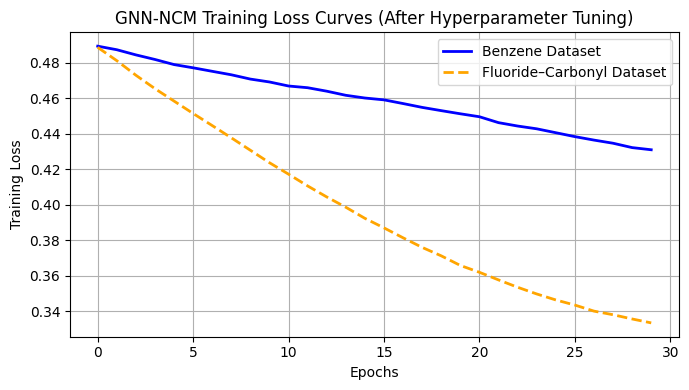

In [39]:
plt.figure(figsize=(7, 4))
plt.plot(benz_losses, label='Benzene Dataset', color='blue', linewidth=2)
plt.plot(fluor_losses, label='Fluoride–Carbonyl Dataset', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('GNN-NCM Training Loss Curves (After Hyperparameter Tuning)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
def compute_node_expressivity(cg, ncm):
    """Compute node expressivity (model output) for each node in the graph."""
    expressivity = {}
    for node in cg.v:
        # Build a mini-NCM centered on this node
        cg.categorize_neighbors(node)
        test_ncm = NCM(cg, node)
        # forward pass without noise
        score = test_ncm.forward(add_noise=False).item()
        expressivity[node] = score
    return expressivity


In [42]:
# Pick one Benzene molecule (guaranteed to have the ring)
benz_smile = random.choice(benzene_smiles)
benz_G, benz_gt = mol_to_nx_and_gt(benz_smile, ["c1ccccc1"])

# Keep picking Fluoride–Carbonyl until we find one that contains the motifs
while True:
    fluor_smile = random.choice(fluoride_smiles)
    fluor_G, fluor_gt = mol_to_nx_and_gt(fluor_smile, ["F", "C=O"])
    if fluor_gt:  # ✅ break only if ground-truth nodes exist
        break

# Build causal graphs
benz_cg = CausalGraph(benz_G.nodes(), benz_G.edges())
fluor_cg = CausalGraph(fluor_G.nodes(), fluor_G.edges())

# Choose one target node per graph to train NCM
benz_target = random.choice(benz_gt)
fluor_target = random.choice(fluor_gt)


IndexError: Cannot choose from an empty sequence

In [43]:
import random

# --- Pick a valid Benzene molecule ---
while True:
    benz_smile = random.choice(benzene_smiles)
    benz_G, benz_gt = mol_to_nx_and_gt(benz_smile, ["c1ccccc1"])
    if benz_gt:  # ✅ break when motif detected
        break

# --- Pick a valid Fluoride–Carbonyl molecule ---
while True:
    fluor_smile = random.choice(fluoride_smiles)
    fluor_G, fluor_gt = mol_to_nx_and_gt(fluor_smile, ["F", "C=O"])
    if fluor_gt:  # ✅ break when motif detected
        break

print(f"✅ Selected Benzene SMILES: {benz_smile}")
print(f"✅ Selected Fluoride–Carbonyl SMILES: {fluor_smile}")
print(f"Benzene motif nodes: {len(benz_gt)} | Fluoride motif nodes: {len(fluor_gt)}")

# Build causal graphs
benz_cg = CausalGraph(benz_G.nodes(), benz_G.edges())
fluor_cg = CausalGraph(fluor_G.nodes(), fluor_G.edges())

# Pick one target node from each motif safely
benz_target = random.choice(benz_gt)
fluor_target = random.choice(fluor_gt)


✅ Selected Benzene SMILES: Cc1c(c(on1)C)S(=O)(=O)[N-]c1nc(cs1)c1ccc(c(c1)Cl)OC
✅ Selected Fluoride–Carbonyl SMILES: c1cc(ccc1c1ccc(s1)/C=C/C(=O)NCCO)F
Benzene motif nodes: 6 | Fluoride motif nodes: 3


In [ ]:
benz_expressivity = compute_node_expressivity(benz_cg, benz_ncm)
fluor_expressivity = compute_node_expressivity(fluor_cg, fluor_ncm)


✅ Selected Benzene SMILES: Cc1cc(ccc1OC)C[N@H+]1CC[C@@H](CC1)[C@]1(C(=O)NC(=O)N1)C
✅ Selected Fluoride–Carbonyl SMILES: CC1(CC(=[OH+])/C(=C/Nc2cc(ccc2N2CCOCC2)Cl)/C(=O)C1)C
Benzene motif nodes: 6 | Fluoride motif nodes: 4


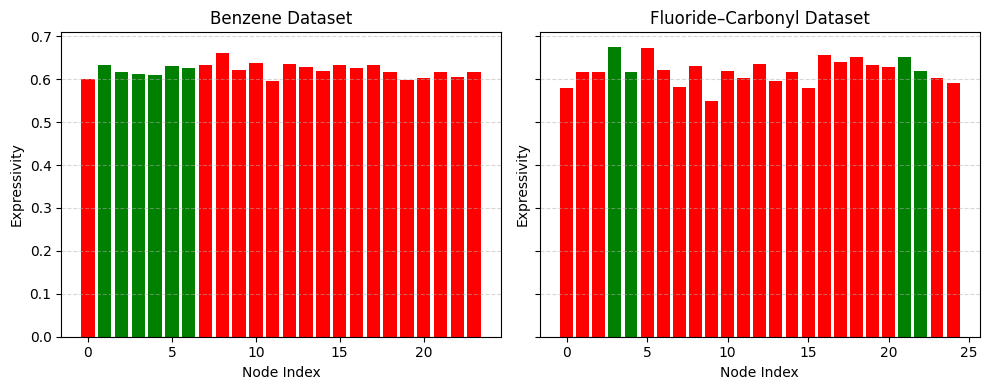

In [45]:
import matplotlib.pyplot as plt
import random

# ============================================================
# 1️⃣ Select valid molecules with motif nodes
# ============================================================
while True:
    benz_smile = random.choice(benzene_smiles)
    benz_G, benz_gt = mol_to_nx_and_gt(benz_smile, ["c1ccccc1"])
    if benz_gt:
        break

while True:
    fluor_smile = random.choice(fluoride_smiles)
    fluor_G, fluor_gt = mol_to_nx_and_gt(fluor_smile, ["F", "C=O"])
    if fluor_gt:
        break

print(f"✅ Selected Benzene SMILES: {benz_smile}")
print(f"✅ Selected Fluoride–Carbonyl SMILES: {fluor_smile}")
print(f"Benzene motif nodes: {len(benz_gt)} | Fluoride motif nodes: {len(fluor_gt)}")

# ============================================================
# 2️⃣ Build causal graphs
# ============================================================
benz_cg = CausalGraph(benz_G.nodes(), benz_G.edges())
fluor_cg = CausalGraph(fluor_G.nodes(), fluor_G.edges())

benz_target = random.choice(benz_gt)
fluor_target = random.choice(fluor_gt)

# ============================================================
# 3️⃣ Train NCMs on each molecule using tuned hyperparameters
# ============================================================
benz_ncm = train_ncm(
    benz_cg, benz_target,
    epochs=benz_params['epochs'],
    lr=benz_params['lr'],
    h_size=benz_params['h_size'],
    h_layers=benz_params['h_layers']
)

fluor_ncm = train_ncm(
    fluor_cg, fluor_target,
    epochs=fluor_params['epochs'],
    lr=fluor_params['lr'],
    h_size=fluor_params['h_size'],
    h_layers=fluor_params['h_layers']
)

# ============================================================
# 4️⃣ Compute node expressivity for each molecule
# ============================================================
def compute_node_expressivity(cg, ncm):
    expressivity = {}
    for node in cg.v:
        cg.categorize_neighbors(node)
        temp_ncm = NCM(cg, node)
        expressivity[node] = temp_ncm.forward(add_noise=False).item()
    return expressivity

benz_expressivity = compute_node_expressivity(benz_cg, benz_ncm)
fluor_expressivity = compute_node_expressivity(fluor_cg, fluor_ncm)

# ============================================================
# 5️⃣ Plot side-by-side expressivity distributions
# ============================================================
def plot_expressivity(expressivity, gt_nodes, title, ax):
    all_nodes = list(expressivity.keys())
    values = [expressivity[n] for n in all_nodes]
    colors = ['green' if n in gt_nodes else 'red' for n in all_nodes]
    ax.bar(range(len(all_nodes)), values, color=colors)
    ax.set_xlabel('Node Index')
    ax.set_ylabel('Expressivity')
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_expressivity(benz_expressivity, benz_gt, "Benzene Dataset", axes[0])
plot_expressivity(fluor_expressivity, fluor_gt, "Fluoride–Carbonyl Dataset", axes[1])

plt.tight_layout()
plt.show()
